<div style='text-align: center;'> 
<h1>Digital Biomarker Discovery for Eye Disorders using EEG Data</h1>
<p>Prepared by Kui Hong Lim<br>
kuihong.lim@students.fhwn.ch<br>
Date : 08 January 2024<br>
Module : Digital Biomarker<br>
Master of Informatics<br>
University of Applied Sciences and Arts Northwestern Switzerland</p>
</div>

***

<h2>Objective</h2>
<p>The objective of this project is to develop a digital biomarker using EEG data that can accurately identify individuals with eye disorders characterized by the need for long and stronger blinks. Students will analyze EEG signals obtained from four electrodes to find a biomarker that can be used to diagnose this eye disorder efficiently.</p>

<h2>Project Tasks</h2>

| Index      | Task |
| ----------- | ----------- |
| 1   | Data download and Preprocessing      |
| 2   | Feature Extraction        |
| 3   | Biomarker Selection and Visualization|
| 4   | Algorithm Development     |
| 5   | Validation and Evaluation |






**1. Data download and preprocessing**

1.1 Data cleaning and understanding

Reading the EEG data from the provided four electrodes by running the file collected during the long blink and short blink session with equal length (510 points pro session). Conduct the preliminary data processing and visualization steps to gain some insight from the EEG recording, started with the long blink data:
- Split and clean the data
- Select the first 510 points for visualization

The initial visualization of the data reveals that the amplitudes of the four signals range from 400 Hz to 1200 Hz. The first, third, and fourth electrode signals exhibit a similar wave pattern with powerline noise, while the second electrode shows less perturbation with powerline noise.

1.2 Load data, and parsing it from string to appropriate data type. Then, select the first 510 points for visualization.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #not used
from scipy import signal
import pywt  #not used



Text(0.5, 1.0, 'The initial 510 to 1020 data points of the long blink segment')

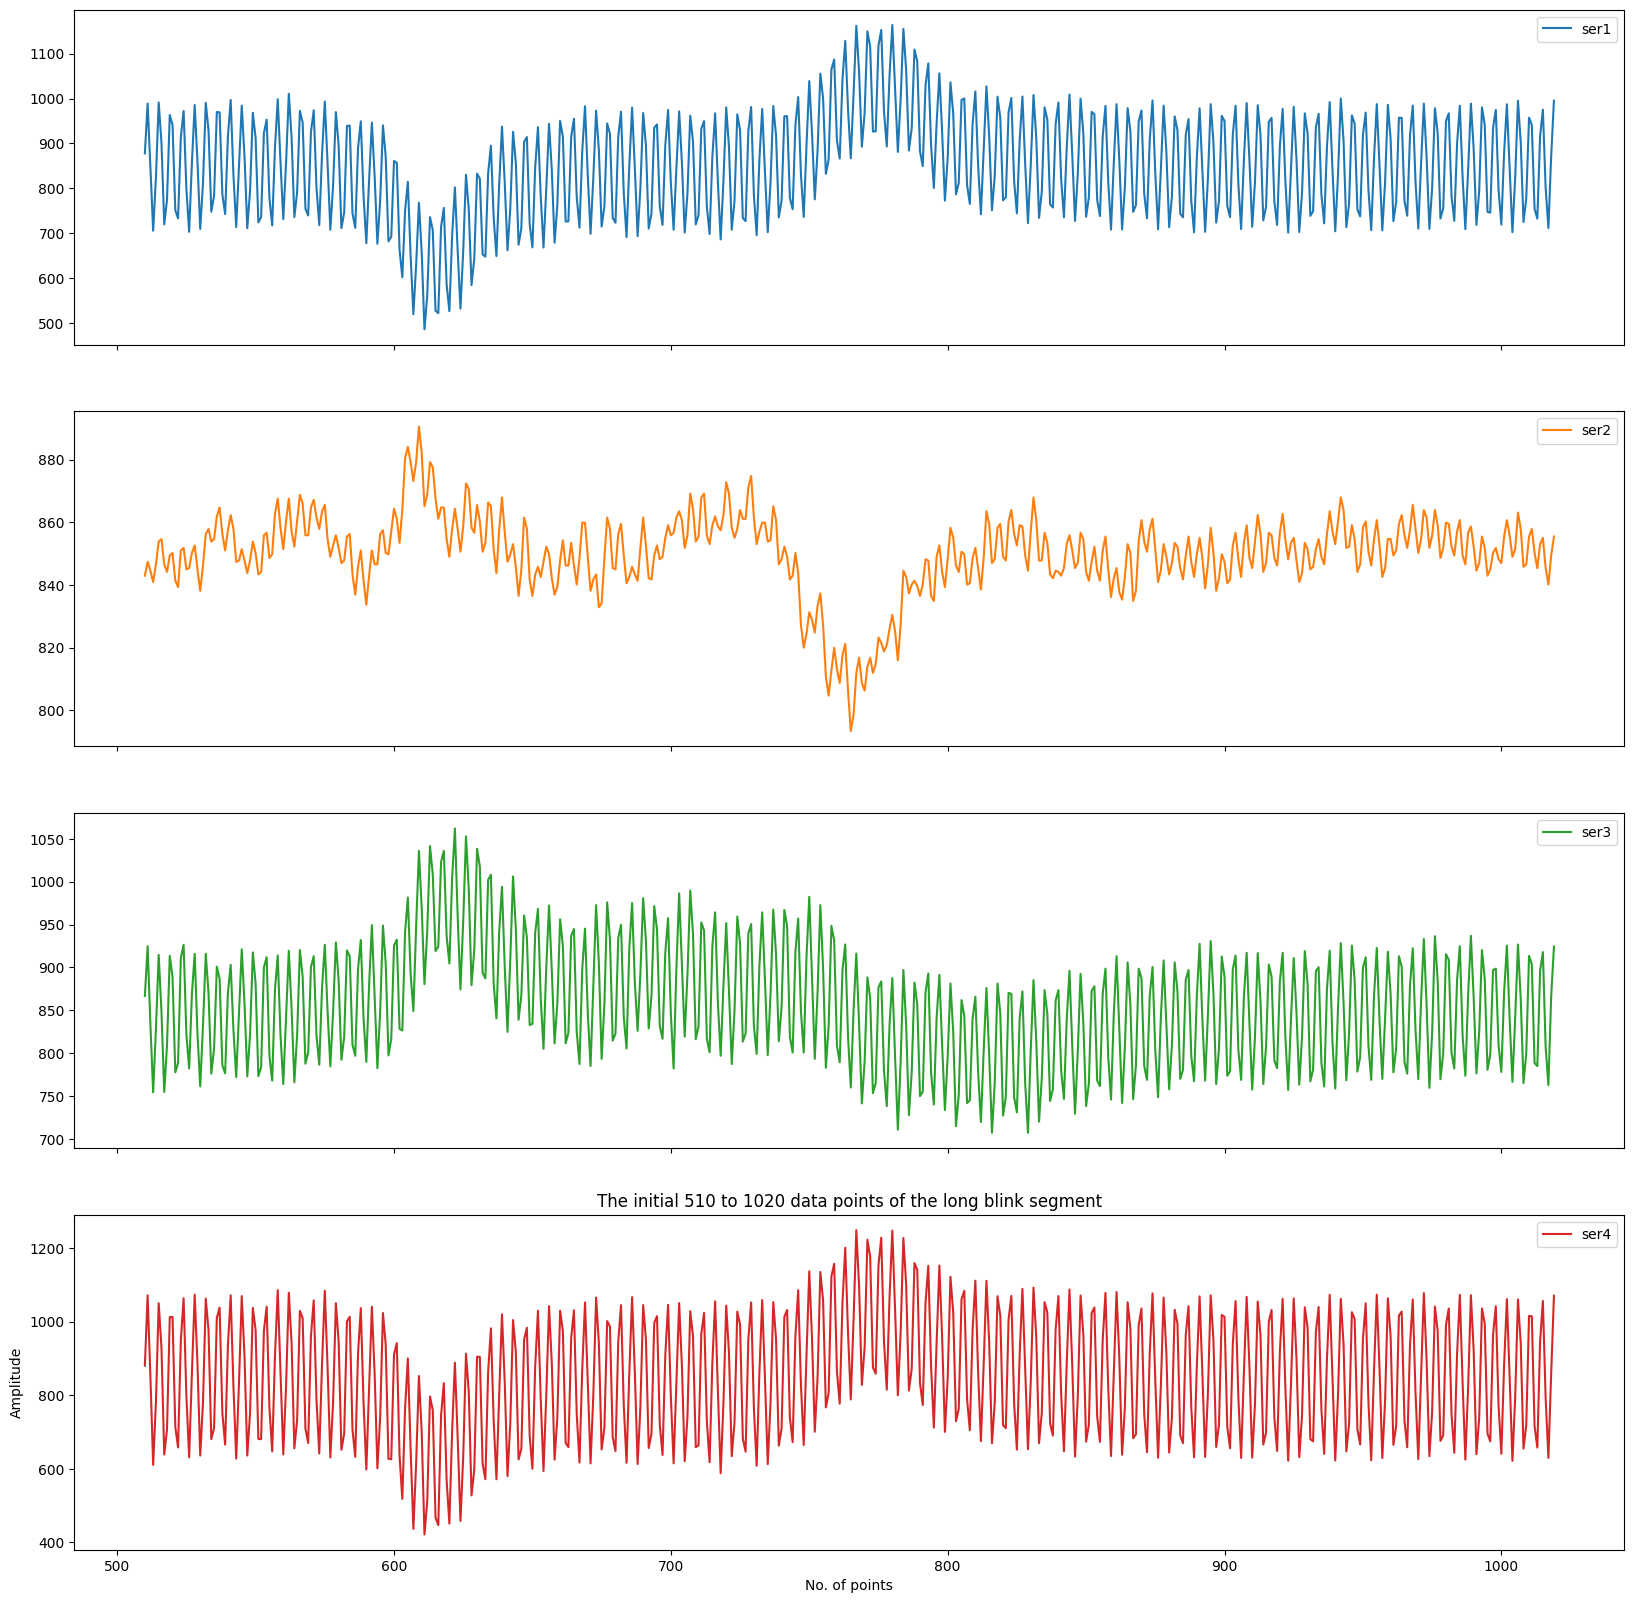

In [2]:
# Long blink data
df1 = pd.read_csv('data\\LongBlink.csv', sep = ",")
df1[['Col1', 'Col2', 'Col3', 'Col4']] = df1['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df1.drop(columns=['data'], inplace=True)
df1.head(5)
ser1 = df1.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
ser2 = df1.iloc[:,1].astype(float) #convert to float
ser3 = df1.iloc[:,2].astype(float) #convert to float
ser4 = df1.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
# ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df1 = pd.concat([ser1, ser2, ser3, ser4], axis=1) #concatenate the columns
df1.columns = ['ser1', 'ser2', 'ser3', 'ser4'] #rename the columns
# Extract the first 510 points of the data as sample and visualize it
df1_sample = df1.iloc[510:1020] 
df1_sample.plot.line(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The initial 510 to 1020 data points of the long blink segment')
#print(ser1[0])

**1. Data download and preprocessing**

1.3 Data format compatibility

In this step, the MNE-Python package is used. MNE is an open source tool for exploring, visualizing, and analyzing human neurophysiological data, such as EEG. A .fif file needs to be generated from csv to fit the raw data format used in this package for analysis.

1.4 Scaling the value 

"A healthy human EEG displays a certain pattern of activity correlate with how awake a person is. The range of frequencies observed are between 1 and 30 Hz, with amplitudes vary between 20 and 100 μV". However, the raw signals of the four electrodes provided exhibit different magnitude range, ("500 - 1100" or "400 - 1200"). 

The objective here is to standardize the magnitude of the variations in the raw signale from the four electrodes into a consistent range between 20 and 100 μV. Standardizing the range helps to achieve consistent and comparable magnitudes across the electrodes. Additionally, scaled data of similar amplitudes can lead to better convergence and efficient training for machine learning. 

In order to rescale the raw signal values to the desired range between 20 and 100 μV, min-max scaling is applied.
Transposing the DataFrame is done to ensure that each row corresponds to a specific time point, which aligns with the typical structure of time-series data. 

1.5 Artifact detection

MNE-Python includes tools for automated detection of certain artifacts such as blinks; one can always visually inspect the data to identify and annotate artifacts as well. Before looking at artifacts, SSP projectors is set aside in a separate variable and then remove them from raw object using del_proj() method so that the data can be inspected in its original, raw state. Signal-space projection (SSP) is a technique for removing noise from EEG signals by projecting the signal onto a lower-dimensional subspace. 

1.6 Apply low-frequency drifts

Low-frequency drifts are most readlily detected by visual inspection using the basic plot() method, it is helpful to plot a relatively long time span and to disable channel-wise DC shift correction. In this context, a 2 seconds is plotted. It is observed that there are approximately 12 pulses occuring every 0.25 seconds. This pattern results in around 50 pulses per second, corresponding to a frequency of 50 Hz. Then the power spectral density is applied to unveil the distribution of power across various frequencies in the EEG signal. 

The Power Spectral Density (PSD) examines how the power of the signal is distributed across different frequencies. The PSD analysis reveals an increase in noise magnitude from 10 Hz to 30 Hz, with a notable peak at 50 Hz, likely indicating power line noise (commonly at 50 Hz in the EU). Additionally, other low-power frequencies are detected around 56 Hz and between 72 to 80 Hz. Given this observation, it is planned to apply a notch filter later, which is commonly use to eliminate specific inteferences frequences such as power line noise. The goal is to mitigate pertubations caused by unwanted frequency in the data. 

***Glossary***
- μV : symbol for microvolts
- Hz : hertz, the unit of frequency in the International System of Units, equivalent to one event per second
- Direct current (DC) shift, also called infraslow activity (IFA), refers to brain activity slower than 0.5 Hz

***Reference***
- [Electroencephalograph](https://en.wikipedia.org/wiki/Electroencephalography#:~:text=A%20healthy%20human%20EEG%20will,between%2020%20and%20100%20%CE%BCV) 

***Reference code***
- [Tutorial MNE RAW EEG CSV](https://colab.research.google.com/drive/1ro2XBhpUKIlV5JCytetKoNFrVOCgdLAP?usp=sharingLink#scrollTo=T4VzMOJKSXlz) 
- [Overview of artifact detection](https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html)  


In [3]:
import mne
from sklearn.preprocessing import MinMaxScaler

n_channels = len(df1.columns) #define number of channels
print(n_channels)
ch_names = list(df1.columns) #list of channel names
print(ch_names)

#Min-max scaling
scaler = MinMaxScaler(feature_range=(0.000020,0.000100))
df_scaled = scaler.fit_transform(df1.to_numpy()) 
df1_norm = pd.DataFrame(df_scaled, columns=df1.columns)
print(df1_norm.head(5))
values = df1_norm.T # transpose the dataframe
ch_types = ['eeg']*df1.shape[1]
sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_lb = mne.io.RawArray(values, info)

raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)
print(values)

4
['ser1', 'ser2', 'ser3', 'ser4']
       ser1      ser2      ser3      ser4
0  0.000058  0.000062  0.000049  0.000059
1  0.000046  0.000057  0.000036  0.000041
2  0.000060  0.000060  0.000055  0.000059
3  0.000076  0.000065  0.000070  0.000081
4  0.000064  0.000061  0.000055  0.000067
Creating RawArray with float64 data, n_channels=4, n_times=25500
    Range : 0 ... 25499 =      0.000 ...   118.600 secs
Ready.
Overwriting existing file.
Writing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
Closing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif
[done]
         0         1         2         3         4         5         6      \
ser1  0.000058  0.000046  0.000060  0.000076  0.000064  0.000045  0.000054   
ser2  0.000062  0.000057  0.000060  0.000065  0.000061  0.000057  0.000060   
ser3  0.000049  0.000036  0.000055  0.000070  0.000055  0.000035  0.000047   
ser4  0.000059  0.000041  0.000059  0.000081  0.000067  0.000041  0.000050   

        

C:\Users\charl\AppData\Local\Temp\ipykernel_16964\2712911562.py:21: RuntimeWarning: This filename (d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_lb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)


In [4]:
ssp_projectors = raw_lb.info['projs'] 
print(raw_lb.del_proj()) #use to remove SSP projection vector
raw_lb.add_proj(ssp_projectors) #use to add SSP projection vector

<RawArray | 4 x 25500 (118.6 s), ~805 kB, data loaded>
0 projection items deactivated


<RawArray | 4 x 25500 (118.6 s), ~805 kB, data loaded>

Using matplotlib as 2D backend.


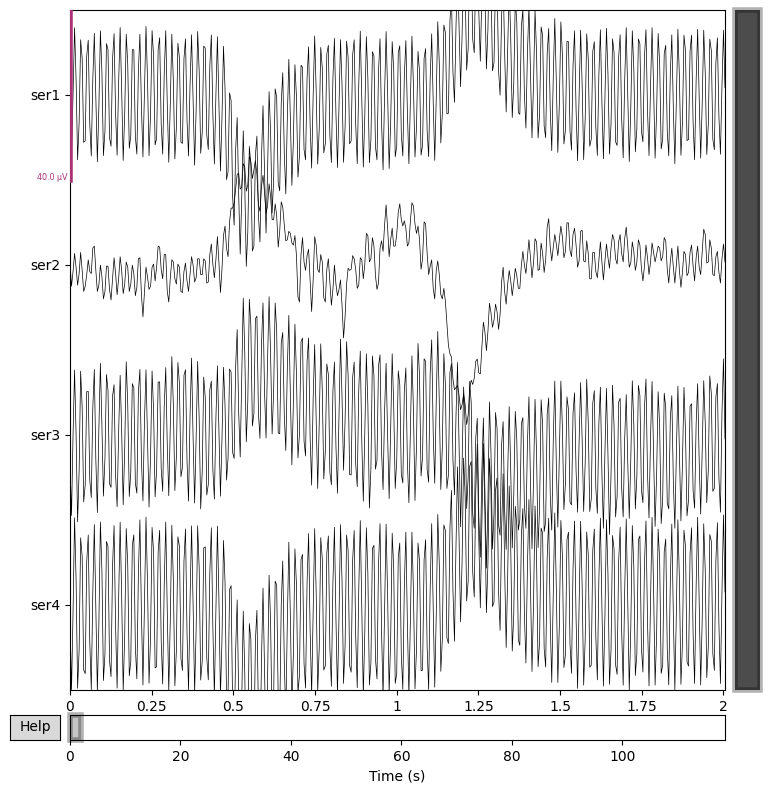

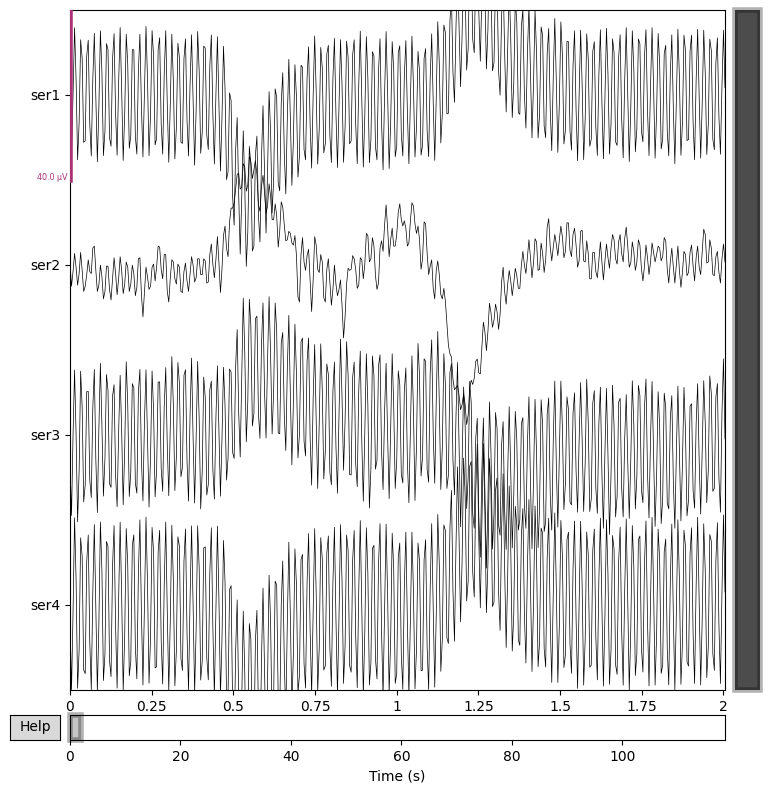

In [5]:
eeg_channel = mne.pick_types(raw_lb.info, eeg=True) 
raw_lb.plot(duration=2, order=eeg_channel, remove_dc=True) 


Effective window size : 9.526 (s)


d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\charl\AppData\Local\Temp\ipykernel_16964\2765107210.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_lb.compute_psd().plot(average=True, picks="data", exclude="bads").show()


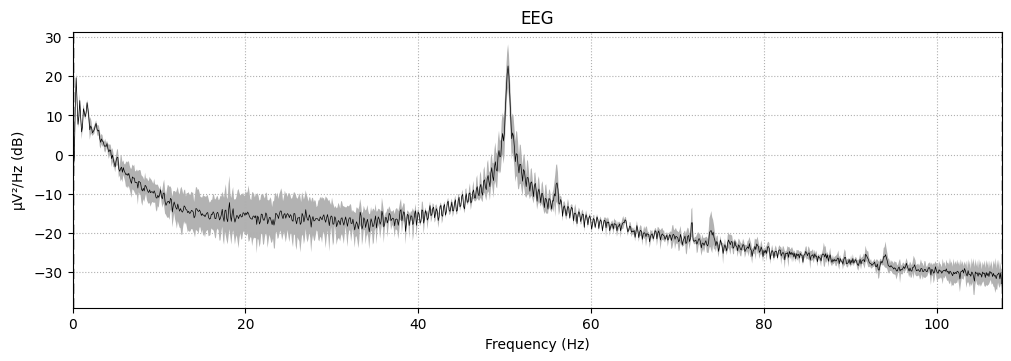

In [6]:
# PSD (power spectral density) provides information about the distribution of power across different frequencies in the EEG signal.
raw_lb.compute_psd().plot(average=True, picks="data", exclude="bads").show()

**1. Data download and preprocessing**

1.7 Filtering EEG data
 
Before commence the filter process, the preprocessed raw data is converted to a DataFrame.

Filtering is the process of removing unwanted frequencies such as noise and artifacts from a signal and preserve the desired frequencies to extract relevant information. 

The filters used during preprocessing are third-order:
* median filter
* low pass filter
* high pass filter
* notch filter

Firstly, a window of data is segmented for further processing, followed by the application of third-order median filter to remove the background noise while retaining important features in the signal. Subsequent processing involved additional filtering steps using both low-pass and high-pass filters. Note that for both the high-pass and low-pass filters, the power does not drop of sharply right at the cutoff frequency, rather, there is a roll-off — a range of frequencies over which the power gradually decreases. The Butterworth filter with a fifth-order design is employed, configuring cutoff frequencies at 0.5 Hertz for the low-pass filter and 50 Hertz for the high-pass filter. The Butterworth filter is known for maintaining a flat frequency response in the passband. To address power interference at 50 Hertz, a notch filter is then applied.

In the final step, a finite impulse response (FIR) filter was designed using the "signal.firwin" function from the SciPy library. FIR filter is widely used for signal processing tasks such as EEG signal processing. This digital filter was configured with 430 taps (coefficients). The cutoff frequencies for this FIR filter were set in the range of 0.01 to 0.06. The lower cutoff frequency of 0.01 Hz is chosen to preserve very low-frequency components in the EEG signal. This includes elements like baseline shifts or gradual trends, which can be important features. The upper cutoff frequency of 0.06 Hz indicates that the filter permits relatively higher-frequency components within the low-frequency range to pass. This selective allowance is designed to capture specific frequency components while mitigating both lower-frequency drifts and potential higher-frequency noise. Essentially, FIR filter is used to isolate targeted frequency components within the EEG signal, striking a balance between retaining essential low-frequency information and minimizing unwanted noise. The chosen cutoff frequencies and the overall design aim to enhance the quality and interpretability of the EEG data for subsequent analyses.

The application of FIRWIN demonstrates a notable improvement in the filtered EEG signal for blinks, resulting in a smoother and cleaner representation compared to the preprocessed state. This enhanced clarity enhances the interpretability and quality of the EEG data for subsequent analyses.

***References***

- [Filtering EEG Data](https://neuraldatascience.io/7-eeg/erp_filtering.html)
-[EEG Signal Processing for Dummies](https://www.neuroelectrics.com/blog/2014/12/18/eeg-signal-processing-for-dummies/)

***Reference code***

- [EEG_signal_processing](https://www.kaggle.com/code/sam1o1/eeg-signal-processing)
- [Filtering EEG signals using SciPy](https://www.daanmichiels.com/blog/2017/10/filtering-eeg-signals-using-scipy/)



In [7]:
# Get pandas dataframe from raw format
data_lb = raw_lb.to_data_frame()
data_lb = data_lb.drop("time", axis=1) #drop "time" column

# Get pandas series to use in data preprocessing
ser1 = data_lb["ser1"]
ser2 = data_lb["ser2"]
ser3 = data_lb["ser3"]
ser4 = data_lb["ser4"]

print(type(ser1))
data_lb

<class 'pandas.core.series.Series'>


ser1       ser2       ser3       ser4
0      58.490141  62.484472  48.958110  58.887317
1      46.140845  57.018634  36.240602  40.556341
2      60.338028  60.496894  55.145005  59.151344
3      76.157746  64.720497  70.440387  81.367280
4      64.033803  61.490683  55.230934  66.808109
...          ...        ...        ...        ...
25495  56.101408  56.521739  51.879699  56.511080
25496  47.087324  57.515528  45.520945  44.403583
25497  61.735211  62.236025  58.324382  61.640736
25498  74.084507  64.223602  67.346939  77.746346
25499  61.509859  58.757764  54.973147  64.016973

[25500 rows x 4 columns]

In [8]:
# Define the slice to display in the following code. Just change the value of 'SLICE_FROM' with 0 or a multiple of 510
SLICE_FROM = 510
SLICE_TO = SLICE_FROM + 510

# Create the median filter function
def median(data: pd.Series | np.ndarray) -> np.ndarray:# pass either one, input: numpy array 1D (one column)
    #applying the median filter
    med_filtered= signal.medfilt(data, kernel_size=3) # applying the median filter order 3 (kernel_size=3)
    return med_filtered # return the med-filtered signal: numpy array 1D

# Create a butterworth bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5) -> tuple:
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data: pd.Series, lowcut: float, highcut: float, fs: float, order=5) -> np.ndarray:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Create notch filter function at 50Hz
def notch_filter(time, band, freq, ripple, order, filter_type, data) -> np.ndarray:

    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = signal.iirfilter(
            order, 
            [low, high], 
            rp=ripple, 
            btype='bandstop',
            analog=False, 
            ftype=filter_type
        )
    
    a = signal.lfilter(b, a, data)
    return a

In [9]:
# Create a preprocessing function

def preprocessing(data: pd.DataFrame, slice_from: int, slice_to: int) -> pd.DataFrame:
    # Define butter bandpass filter parameters
    lowcut = 0.5
    highcut = 40
    fs = 215
    order = 4
    
    # Define notch filter parameters
    time = 1/215
    band = 4
    freq = 50
    ripple = 1
    order = 2
    filter_type = 'butter'

    # Create an empty pandas DataFrame
    cleaned_data = pd.DataFrame()

    # Loop through all columns and apply the filters
    for key, value in data.items():

        # for each column plot all the filters results
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15,25)) # 4 rows, 1 column

        # apply median filter
        series_mf = median(value)

        # apply butter bandpass filter
        series_bbf = butter_bandpass_filter(series_mf, lowcut, highcut, fs, order)

        # apply notch filter
        series_nf = notch_filter(time, band, freq, ripple, order, filter_type, series_bbf)

        # add the processed data to the dataframe
        cleaned_data[key] = series_nf

        # plot each steps ax0 raw value, ax1 after butter bandpass, ax2 after median, ax3 after notch filter.
        ax0.plot(value[slice_from:slice_to])
        ax0.set_title('Raw data')
        ax0.set_xlabel('Data Point')
        ax0.set_ylabel('Amplitude (\u03BCV)')

        ax1.plot(series_mf[slice_from:slice_to], color="orange")
        ax1.set_title('After median filter')
        ax1.set_xlabel('Data Point')
        ax1.set_ylabel('Amplitude (\u03BCV)')

        ax2.plot(series_bbf[slice_from:slice_to], color="red")
        ax2.set_title('+ butter bandpass filter')
        ax2.set_xlabel('Data Point')
        ax2.set_ylabel('Amplitude (\u03BCV)')


        ax3.plot(series_nf[slice_from:slice_to], color="green")
        ax3.set_title('+ notch filter')
        ax3.set_xlabel('Data Point')
        ax3.set_ylabel('Amplitude (\u03BCV)')

        
        fig.suptitle(f"Filters apply to '{key}'")

    return cleaned_data

            ser1       ser2       ser3       ser4
0       7.681072   9.491899   6.032978   6.751419
1      28.549825  33.319081  22.926410  26.338979
2      49.560767  54.099221  41.447948  47.628816
3      60.726091  62.369908  52.704267  60.160793
4      63.929381  62.665218  56.046259  65.219784
...          ...        ...        ...        ...
25495  -0.296273  -8.718308   4.212854  -1.313726
25496  -0.105815  -7.483555   3.479435  -0.689297
25497   1.640987  -4.783757   3.418332   1.957232
25498   0.575097  -3.280914   2.204631   0.974806
25499  -2.381204  -3.996623   0.095607  -2.072305

[25500 rows x 4 columns]


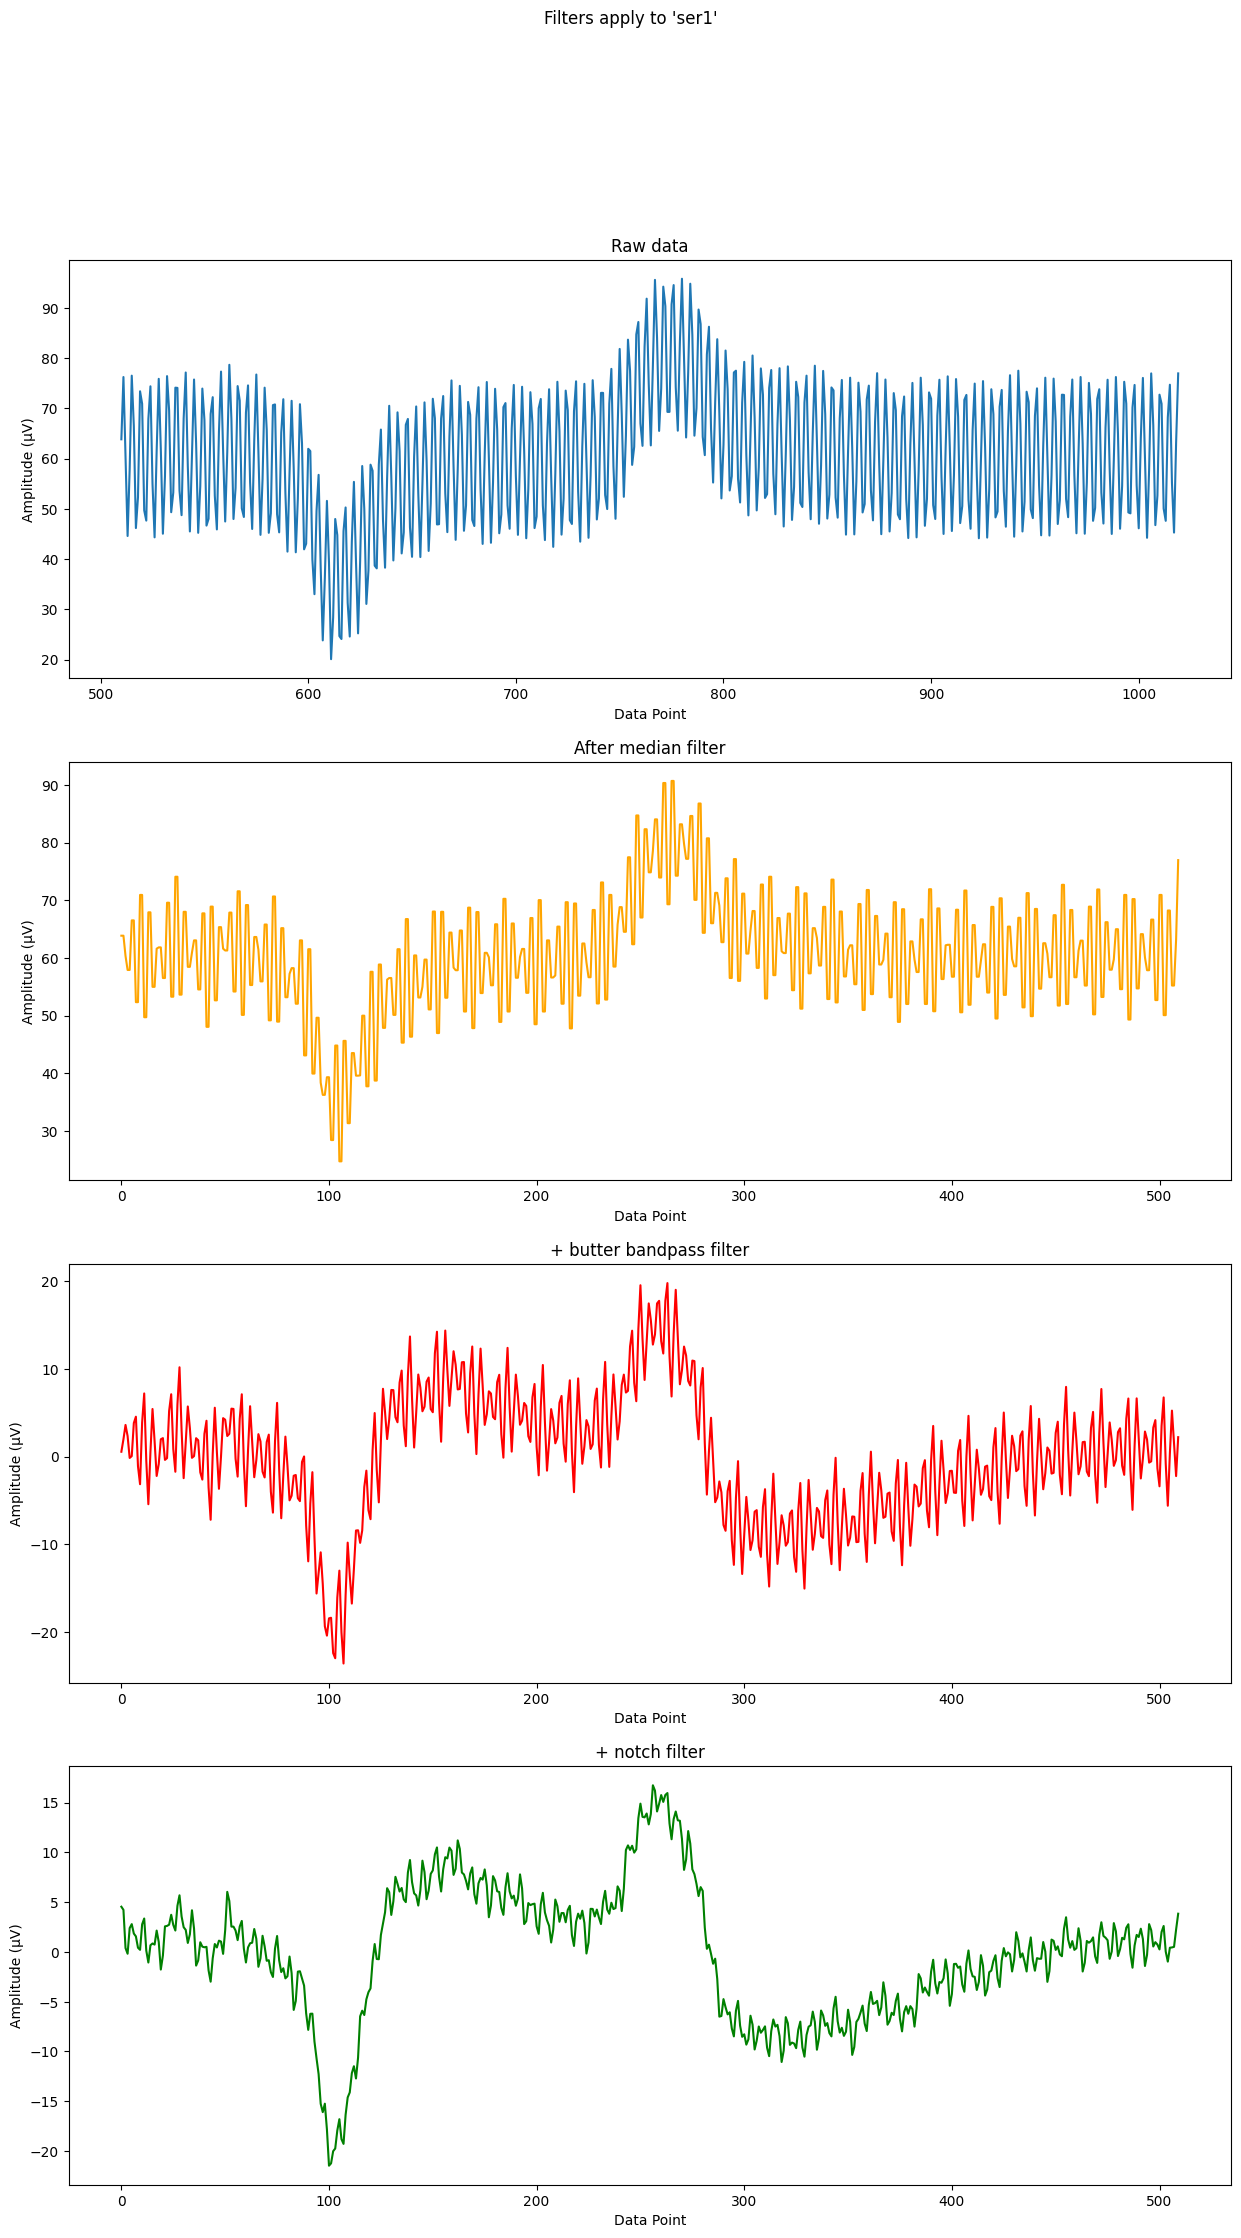

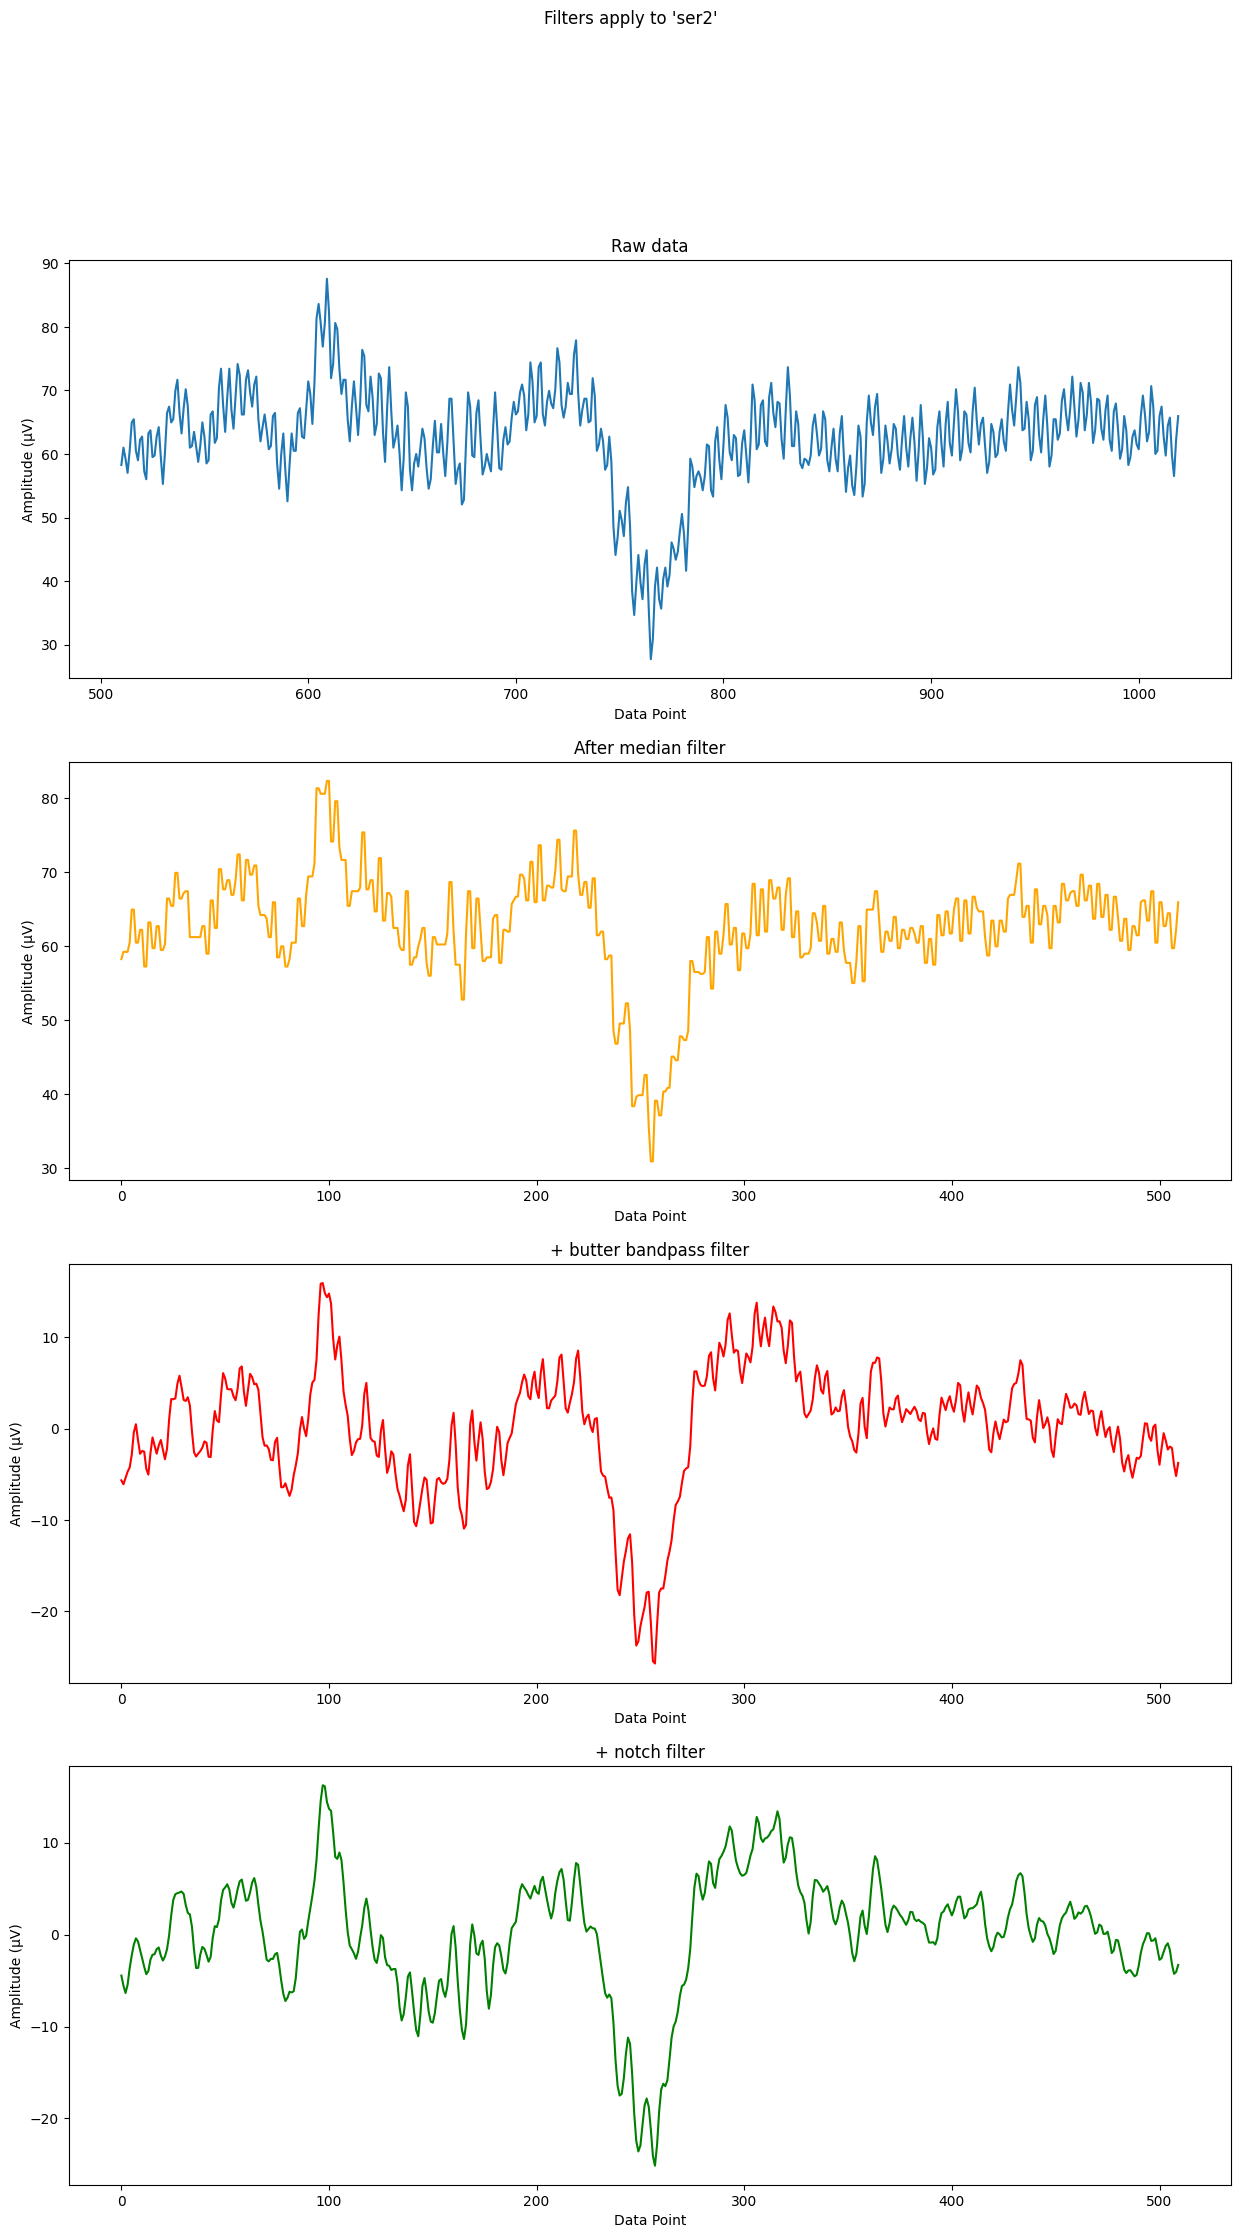

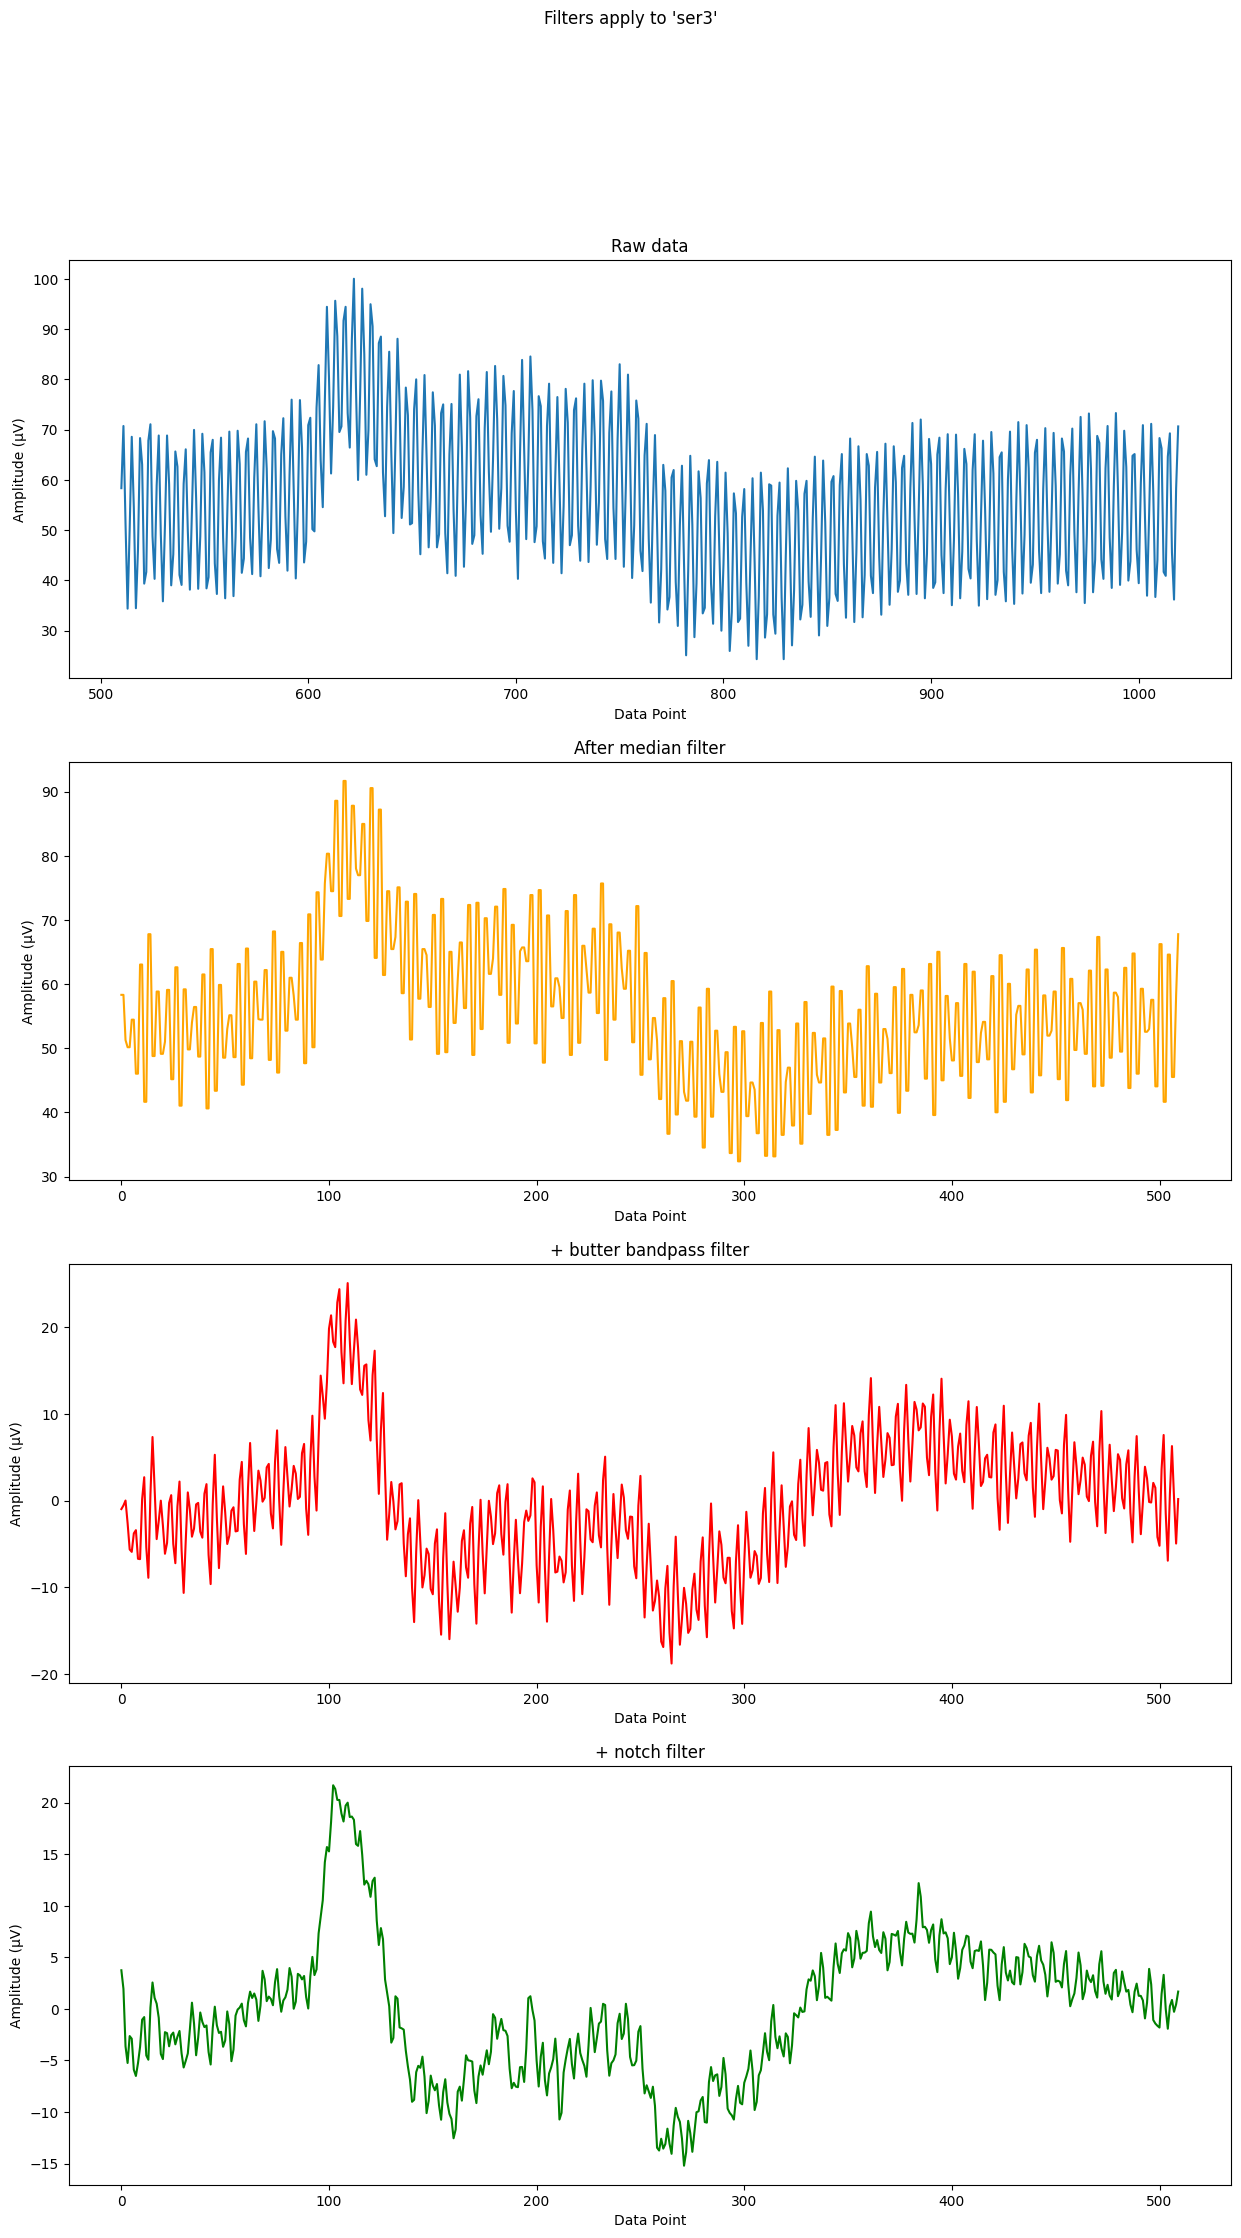

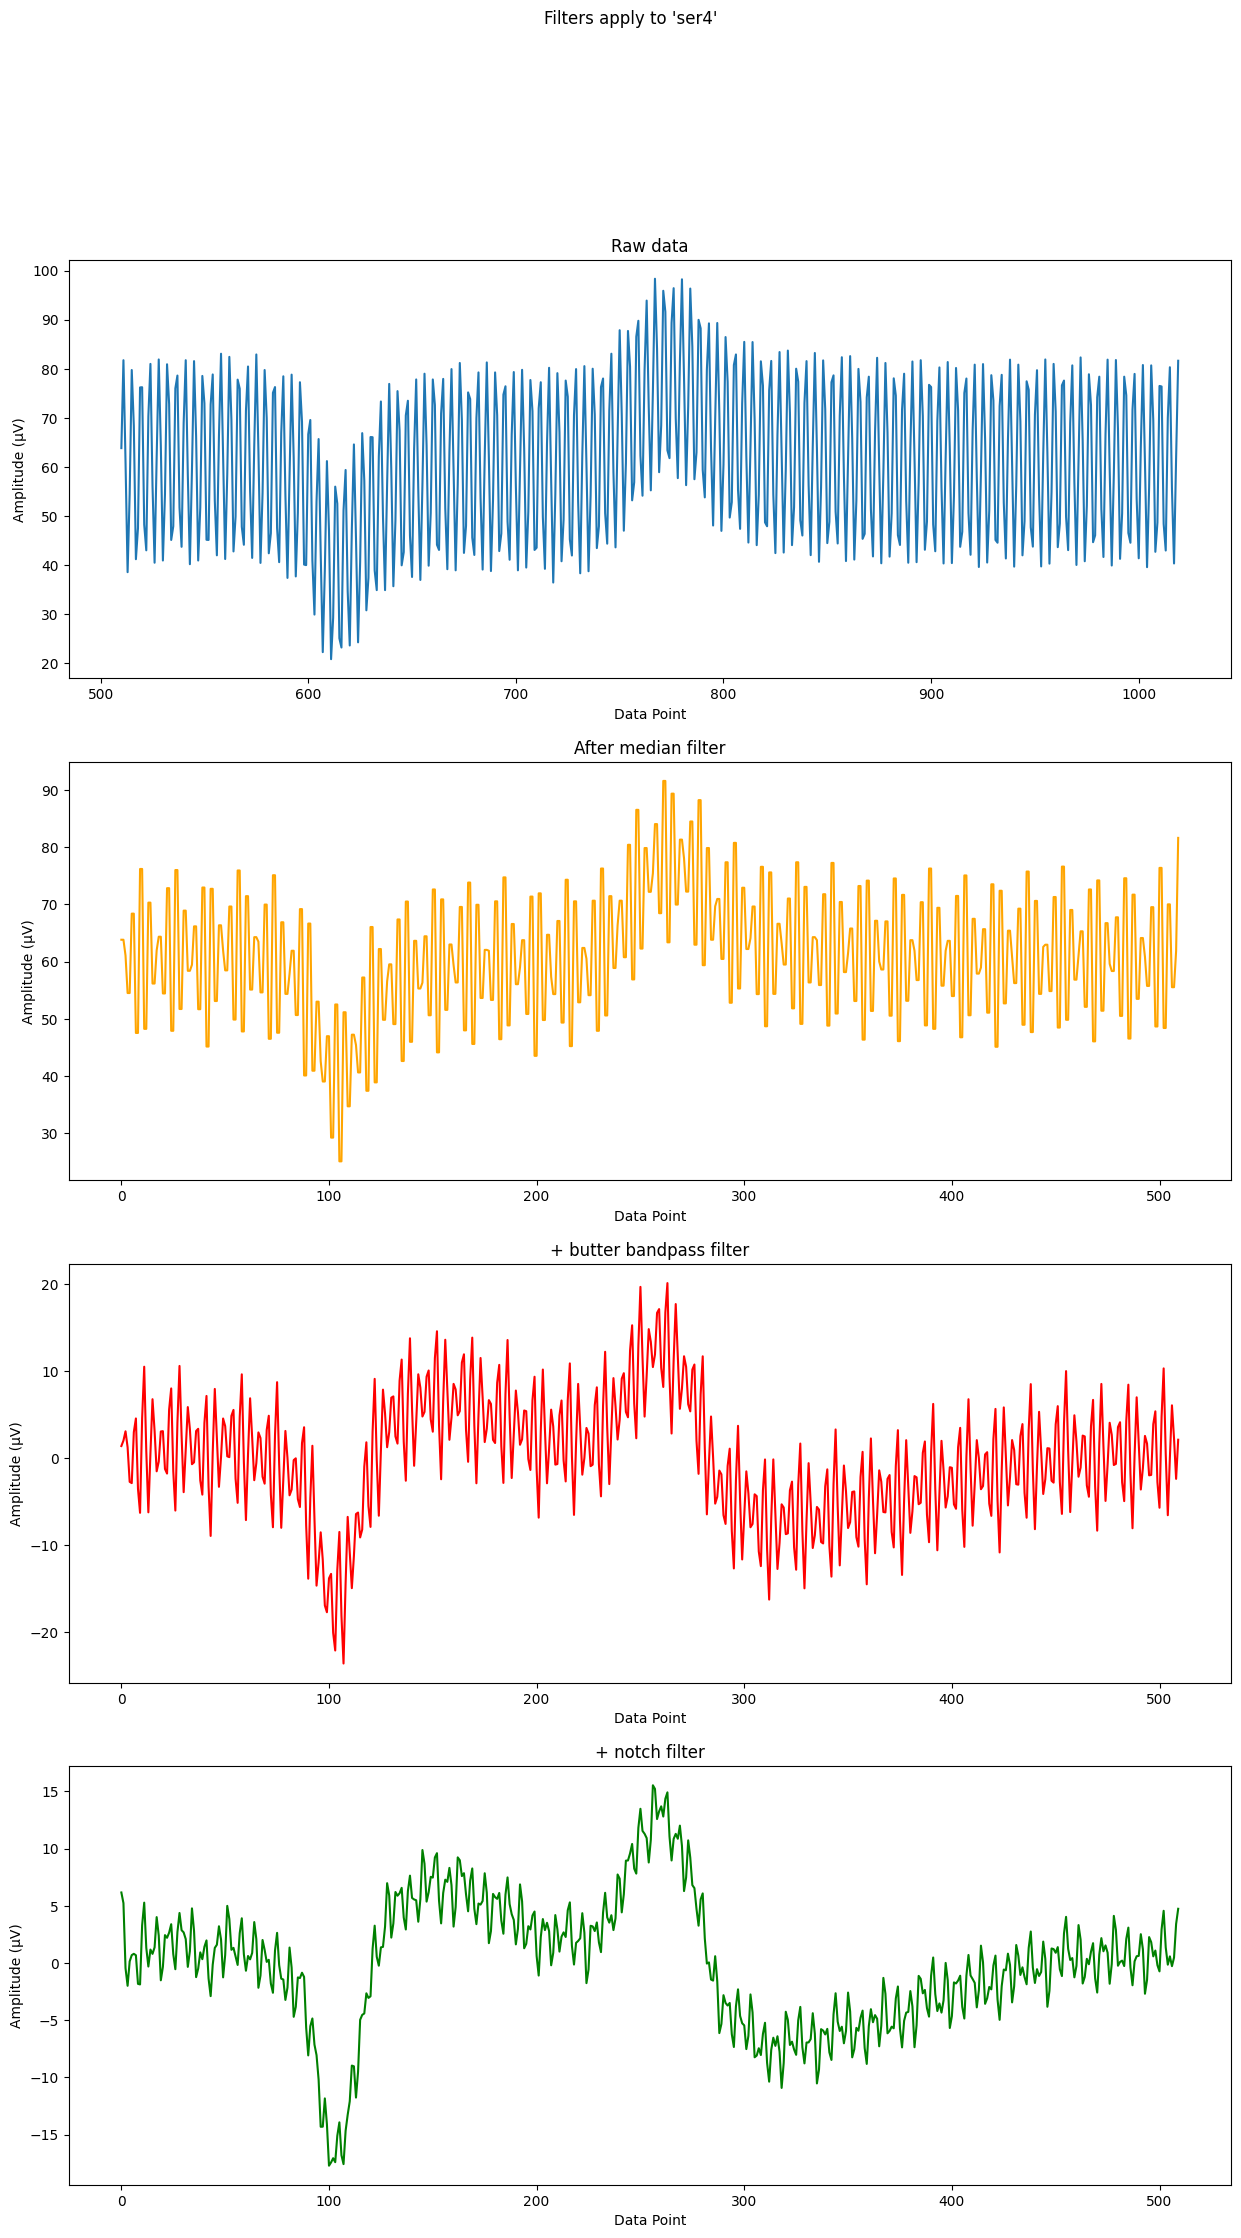

In [10]:
lb_cleaned = preprocessing(data_lb, SLICE_FROM, SLICE_TO)
print(lb_cleaned)


In [11]:
# Create a FIR filter function
cutoff_freq = [0.01, 0.06] #Hz
filter = signal.firwin(430, [0.01, 0.06], pass_zero=False)

# Visualize the filter
# plt.figure(figsize=(12, 6))
# plt.plot(filter)
# plt.title("Filtered EEG Data")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [12]:
# Create a comparison plot function
def plot_compare(
        df_original: np.ndarray | pd.DataFrame, 
        df_cleaned: np.ndarray | pd.DataFrame,
        slice_from: int, 
        slice_to: int, 
        color_original: str="green", 
        color_cleaned: str="orange",
        name: str=""
) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
    ax1.plot(df_original[slice_from:slice_to], color_original)
    ax2.plot(df_cleaned[slice_from:slice_to], color_cleaned)
    fig.suptitle(f"Before and after signal processing {name}")

In [13]:
# Create a function to apply the filter
def processing_fir_filter(df: pd.DataFrame, filter_function: signal.filter_design) -> pd.DataFrame:
    filtered_data = pd.DataFrame()
    for key, value in df.items():
        processed_data = signal.convolve(value, filter_function, mode='same')

        # plot results
        plot_compare(df[key], processed_data, SLICE_FROM, SLICE_TO, name=f"{key}")
        # add the processed data to the dataframe
        filtered_data[key] = processed_data

    return filtered_data

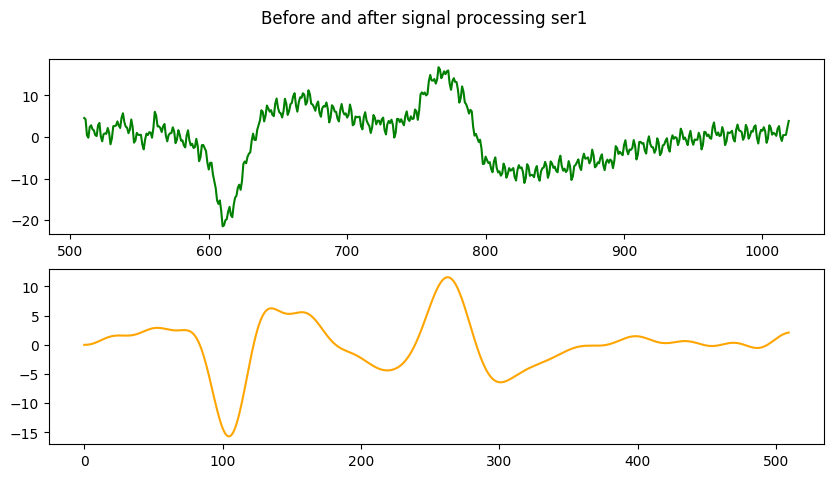

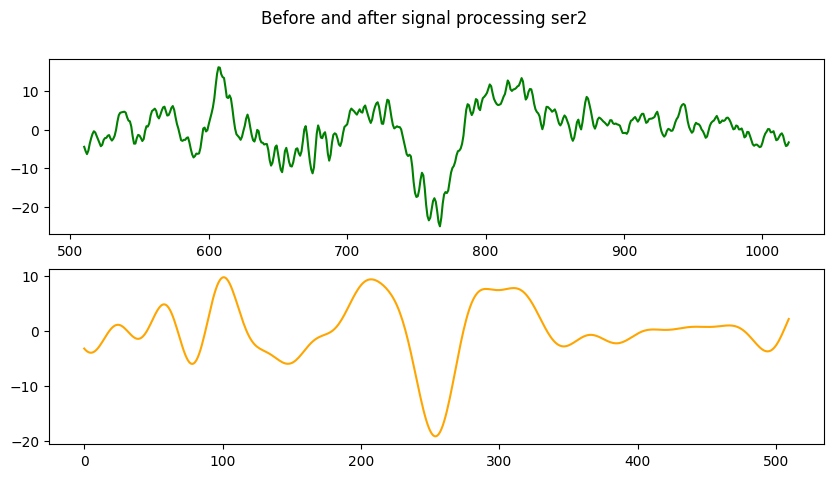

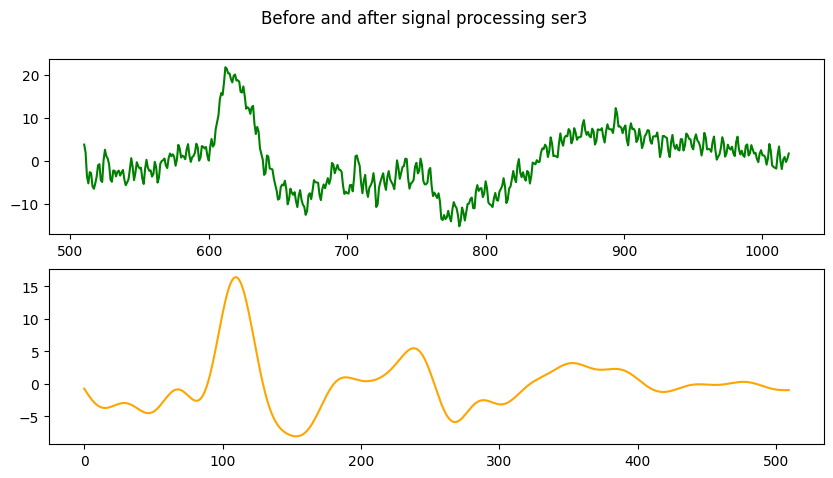

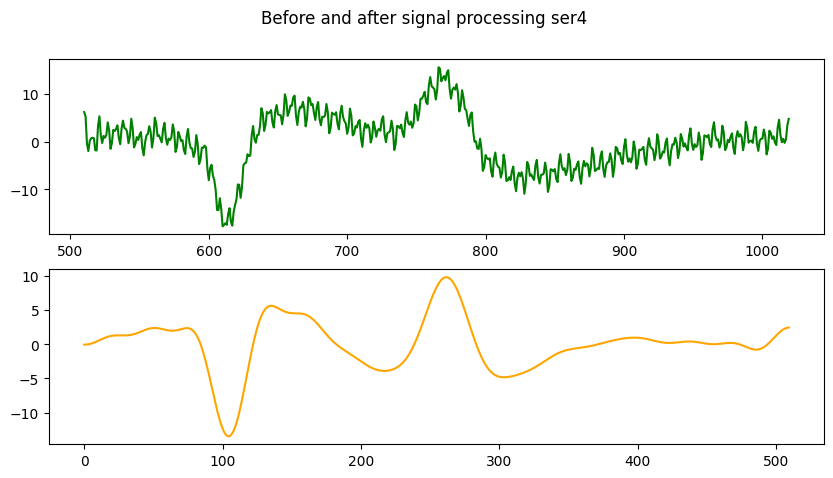

In [14]:
# Apply signal.firwin function : FIR (finite impulse response) filter to process the signal in series 1 and compare the results
lb_filtered = processing_fir_filter(lb_cleaned, filter)

**1. Data download and preprocessing**

1.8 Data preprocessing and filtering on short blink data

The same steps to process and filter long blink data are applied on the short blink data. In contrast to the long blink data, the short blink data exhibits reduced power line noise. However, it is affected by artifacts and noises within the amplitude range of 600 Hz to 900 Hz. Many small fluctuations are noticed before the rise or descent to the peak at 60 seconds (an indication of eye blink). The Power Spectral Density (PSD) analysis indicates a gradual increase in noise from 10 Hz towards the end of the segment, featuring a distinct peak at around 56 Hz.

Text(0.5, 1.0, 'The initial 510 to 1020 points of short blink segment')

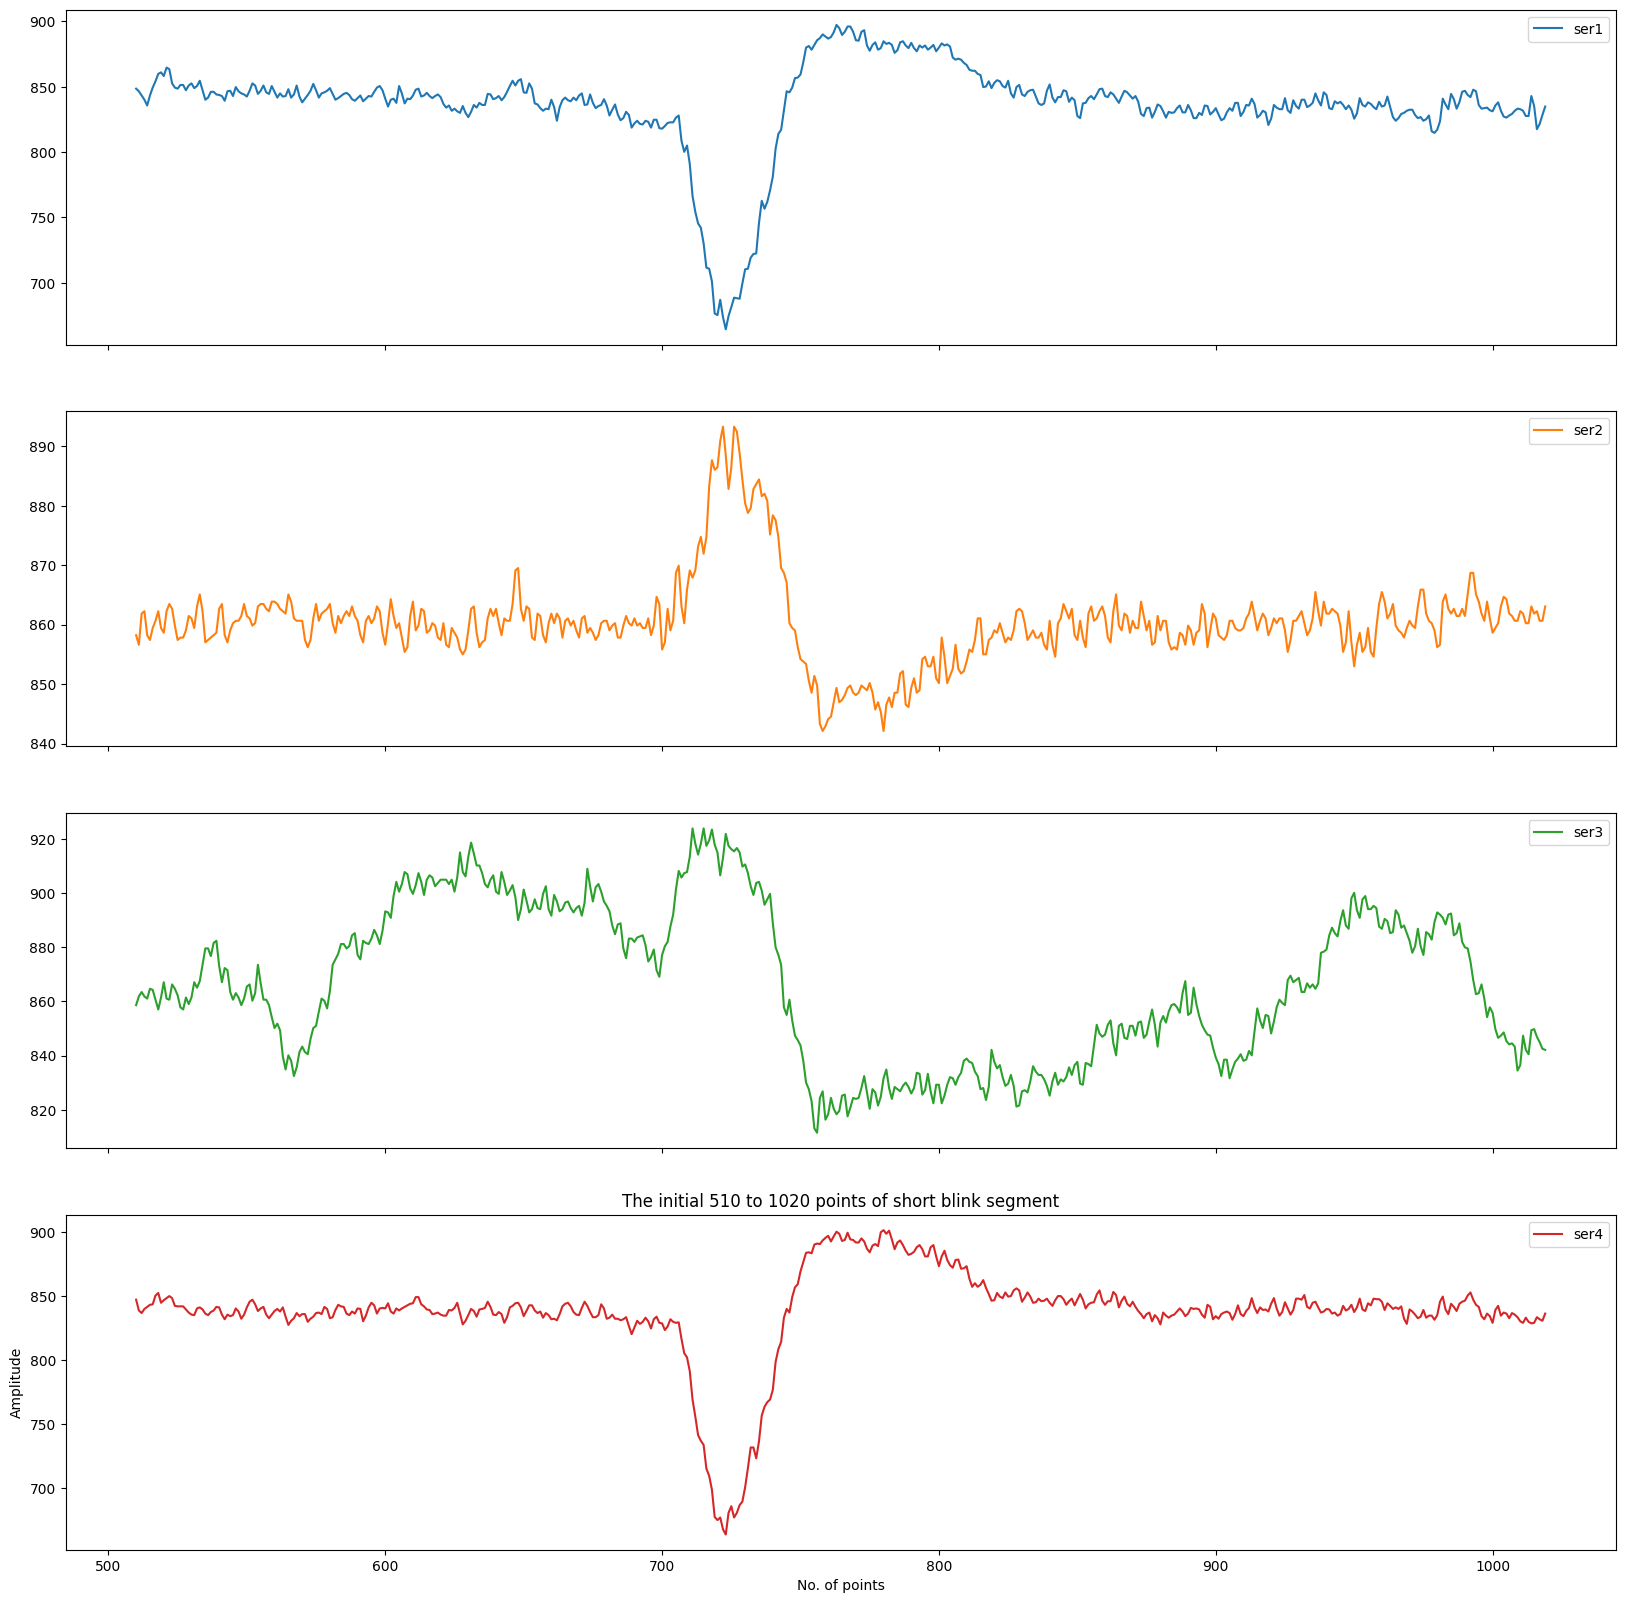

In [15]:
# Short blink data
df2 = pd.read_csv('data\\ShortBlink.csv', sep = ",")
df2[['Col1', 'Col2', 'Col3', 'Col4']] = df2['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df2.drop(columns=['data'], inplace=True)
df2.head(5)
ser1 = df2.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
ser2 = df2.iloc[:,1].astype(float) #convert to float
ser3 = df2.iloc[:,2].astype(float) #convert to float
ser4 = df2.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
# ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df2 = pd.concat([ser1, ser2, ser3, ser4], axis=1) #concatenate the columns
df2.columns = ['ser1', 'ser2', 'ser3', 'ser4'] #rename the columns
# Extract the first 510 points of the data as sample and visualize it
df2_sample = df2.iloc[510:1020] 
df2_sample.plot(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The initial 510 to 1020 points of short blink segment')
#print(sb_ser1[0])

In [16]:
import mne
from sklearn.preprocessing import MinMaxScaler

n_channels = len(df2.columns) #define number of channels
print(n_channels)
ch_names = list(df2.columns) #list of channel names
print(ch_names)

# Min-max scaling
scaler = MinMaxScaler(feature_range=(0.000020,0.000100))
df2_scaled = scaler.fit_transform(df2.to_numpy()) 
df2_norm = pd.DataFrame(df2_scaled, columns=df2.columns)

values = df2_norm.T # transpose the dataframe
ch_types = ['eeg']*df2.shape[1]
sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_sb = mne.io.RawArray(values, info)

raw_sb.save('.\\data\\raw_sb.fif', overwrite=True)
print(values)

4
['ser1', 'ser2', 'ser3', 'ser4']
Creating RawArray with float64 data, n_channels=4, n_times=25500
    Range : 0 ... 25499 =      0.000 ...   118.600 secs
Ready.
Overwriting existing file.
Writing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_sb.fif
Closing d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_sb.fif
[done]
         0         1         2         3         4         5         6      \
ser1  0.000074  0.000074  0.000072  0.000069  0.000071  0.000073  0.000075   
ser2  0.000045  0.000049  0.000054  0.000051  0.000050  0.000047  0.000048   
ser3  0.000074  0.000074  0.000070  0.000067  0.000069  0.000067  0.000064   
ser4  0.000077  0.000076  0.000075  0.000073  0.000071  0.000073  0.000075   

         7         8         9      ...     25490     25491     25492  \
ser1  0.000076  0.000074  0.000077  ...  0.000081  0.000081  0.000082   
ser2  0.000050  0.000047  0.000048  ...  0.000041  0.000043  0.000042   
ser3  0.000062  0.000065  0.000063  ...  

C:\Users\charl\AppData\Local\Temp\ipykernel_16964\3194721739.py:21: RuntimeWarning: This filename (d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\data\raw_sb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sb.save('.\\data\\raw_sb.fif', overwrite=True)


<RawArray | 4 x 25500 (118.6 s), ~805 kB, data loaded>
0 projection items deactivated


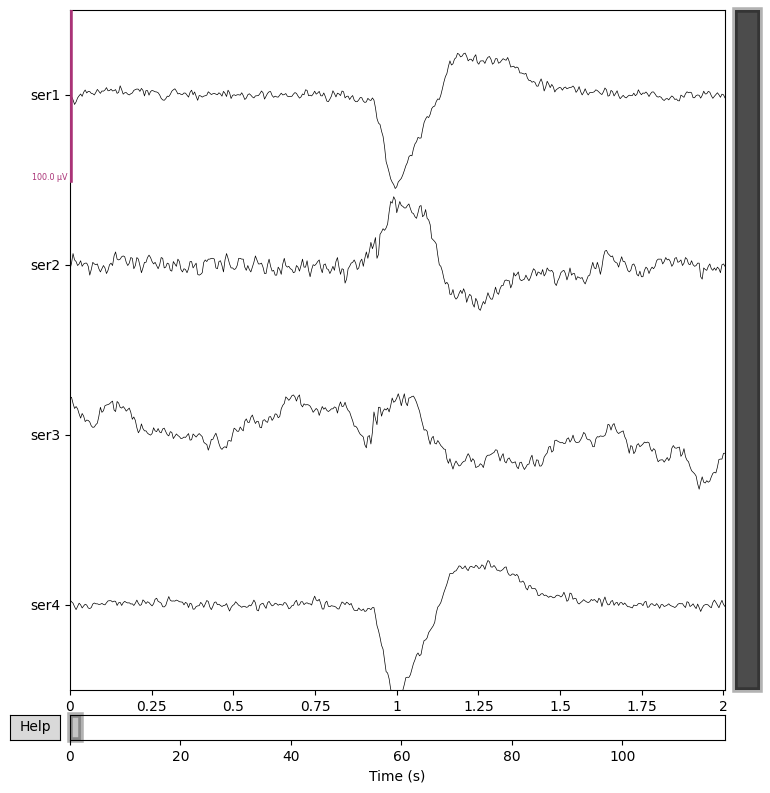

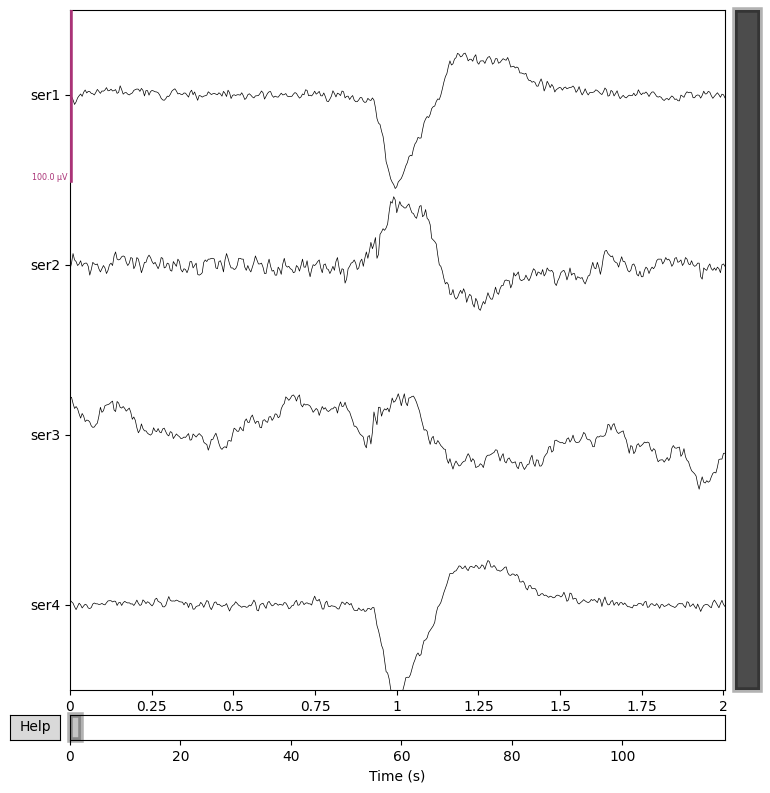

In [17]:
ssp_projectors = raw_sb.info['projs'] 
print(raw_sb.del_proj()) #use to remove SSP projection vector
raw_sb.add_proj(ssp_projectors) #use to add SSP projection vector
eeg_channel = mne.pick_types(raw_sb.info, eeg=True) 
raw_sb.plot(duration=2, order=eeg_channel, remove_dc=True, scalings=dict(eeg=50e-6)) 


Effective window size : 9.526 (s)


d:\FHNW_Medical_Informatics\Python\Python_Learn\EEG\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\charl\AppData\Local\Temp\ipykernel_16964\2335073159.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  raw_sb.compute_psd().plot(average=True, picks="data", exclude="bads").show()


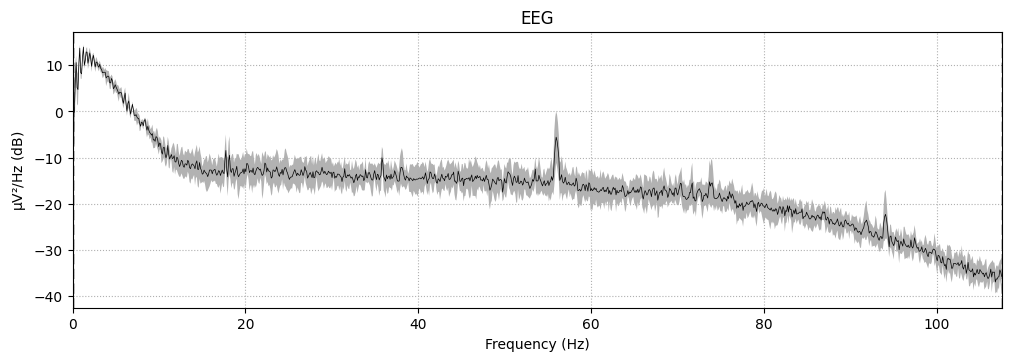

In [18]:
raw_sb.compute_psd().plot(average=True, picks="data", exclude="bads").show()

In [19]:
# Get pandas dataframe from raw format
data_sb = raw_sb.to_data_frame()
data_sb = data_sb.drop("time", axis=1) #drop "time" column

# Get pandas series to use in data preprocessing
ser1 = data_sb["ser1"]
ser2 = data_sb["ser2"]
ser3 = data_sb["ser3"]
ser4 = data_sb["ser4"]

print(type(ser1))
data_sb

<class 'pandas.core.series.Series'>


ser1       ser2       ser3       ser4
0      73.994169  44.941176  73.636364  76.829268
1      74.227405  48.705882  74.090909  75.731707
2      72.128280  54.352941  70.454545  74.878049
3      69.446064  50.588235  67.500000  72.804878
4      70.962099  49.647059  68.636364  71.097561
...          ...        ...        ...        ...
25495  82.973761  39.294118  48.181818  80.853659
25496  81.457726  45.882353  43.409091  75.609756
25497  79.241983  45.882353  41.363636  74.024390
25498  80.058309  44.000000  42.954545  77.195122
25499  81.574344  44.941176  42.954545  75.853659

[25500 rows x 4 columns]

            ser1       ser2       ser3       ser4
0      12.317819   7.481363  12.258255  12.607067
1      42.487393  26.431899  42.281941  43.485086
2      67.303154  43.541016  66.757138  69.059373
3      75.333817  51.044385  74.099270  77.562765
4      73.533985  51.564544  71.400914  75.720633
...          ...        ...        ...        ...
25495   2.475433  -1.539060   1.557774   1.645603
25496   2.131697  -1.611922   1.164475   0.619021
25497   1.409376  -0.293050   0.196334  -1.424614
25498   0.261482   1.438902  -0.986836  -3.135031
25499  -0.744026   2.075746  -1.791414  -3.814898

[25500 rows x 4 columns]


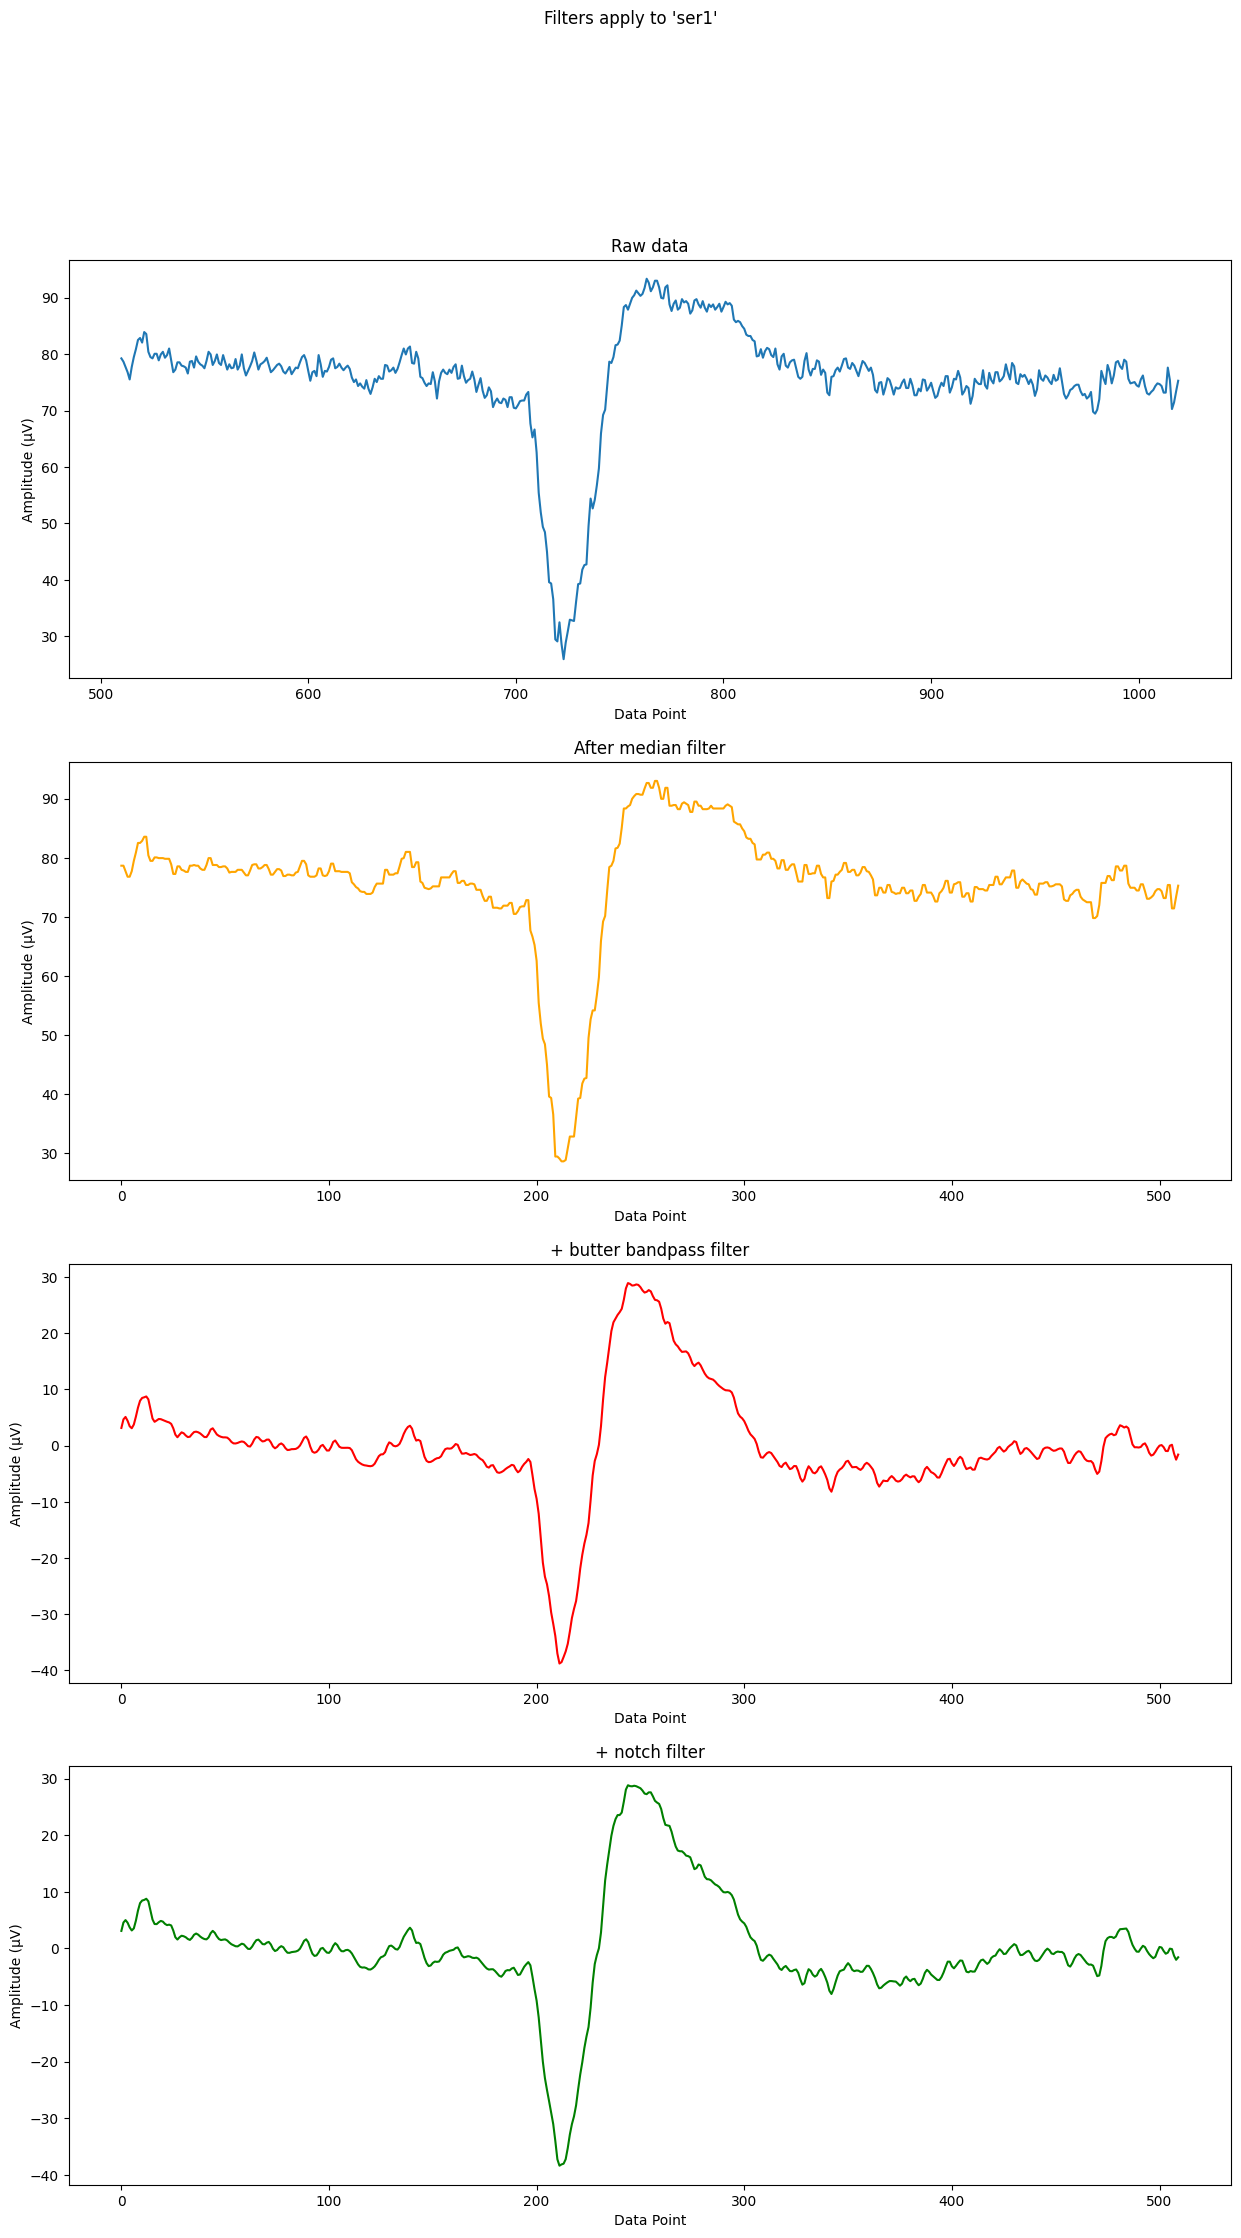

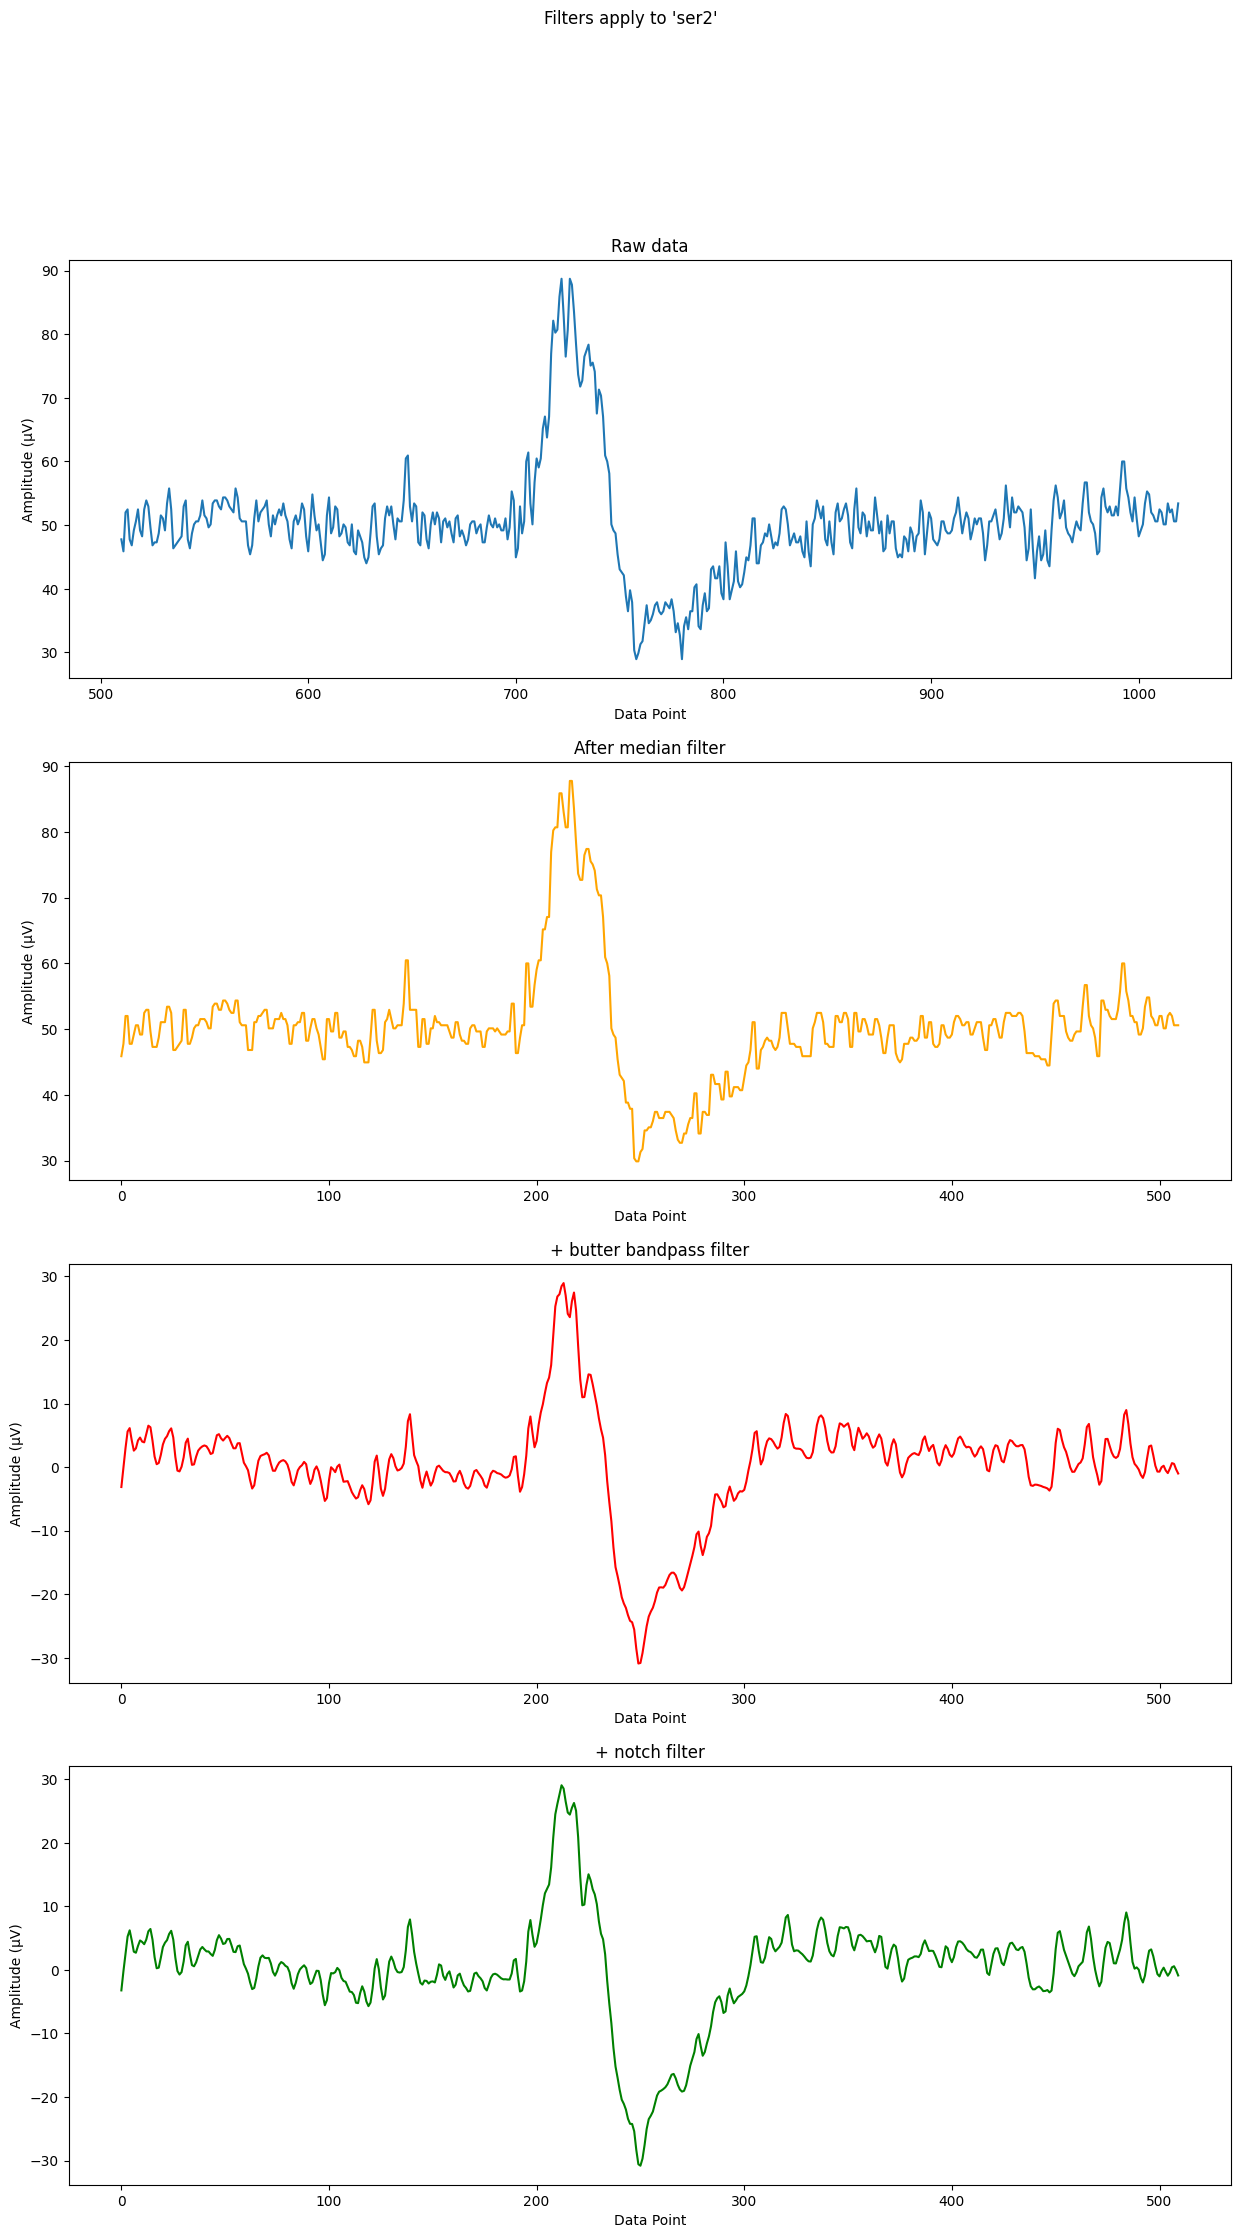

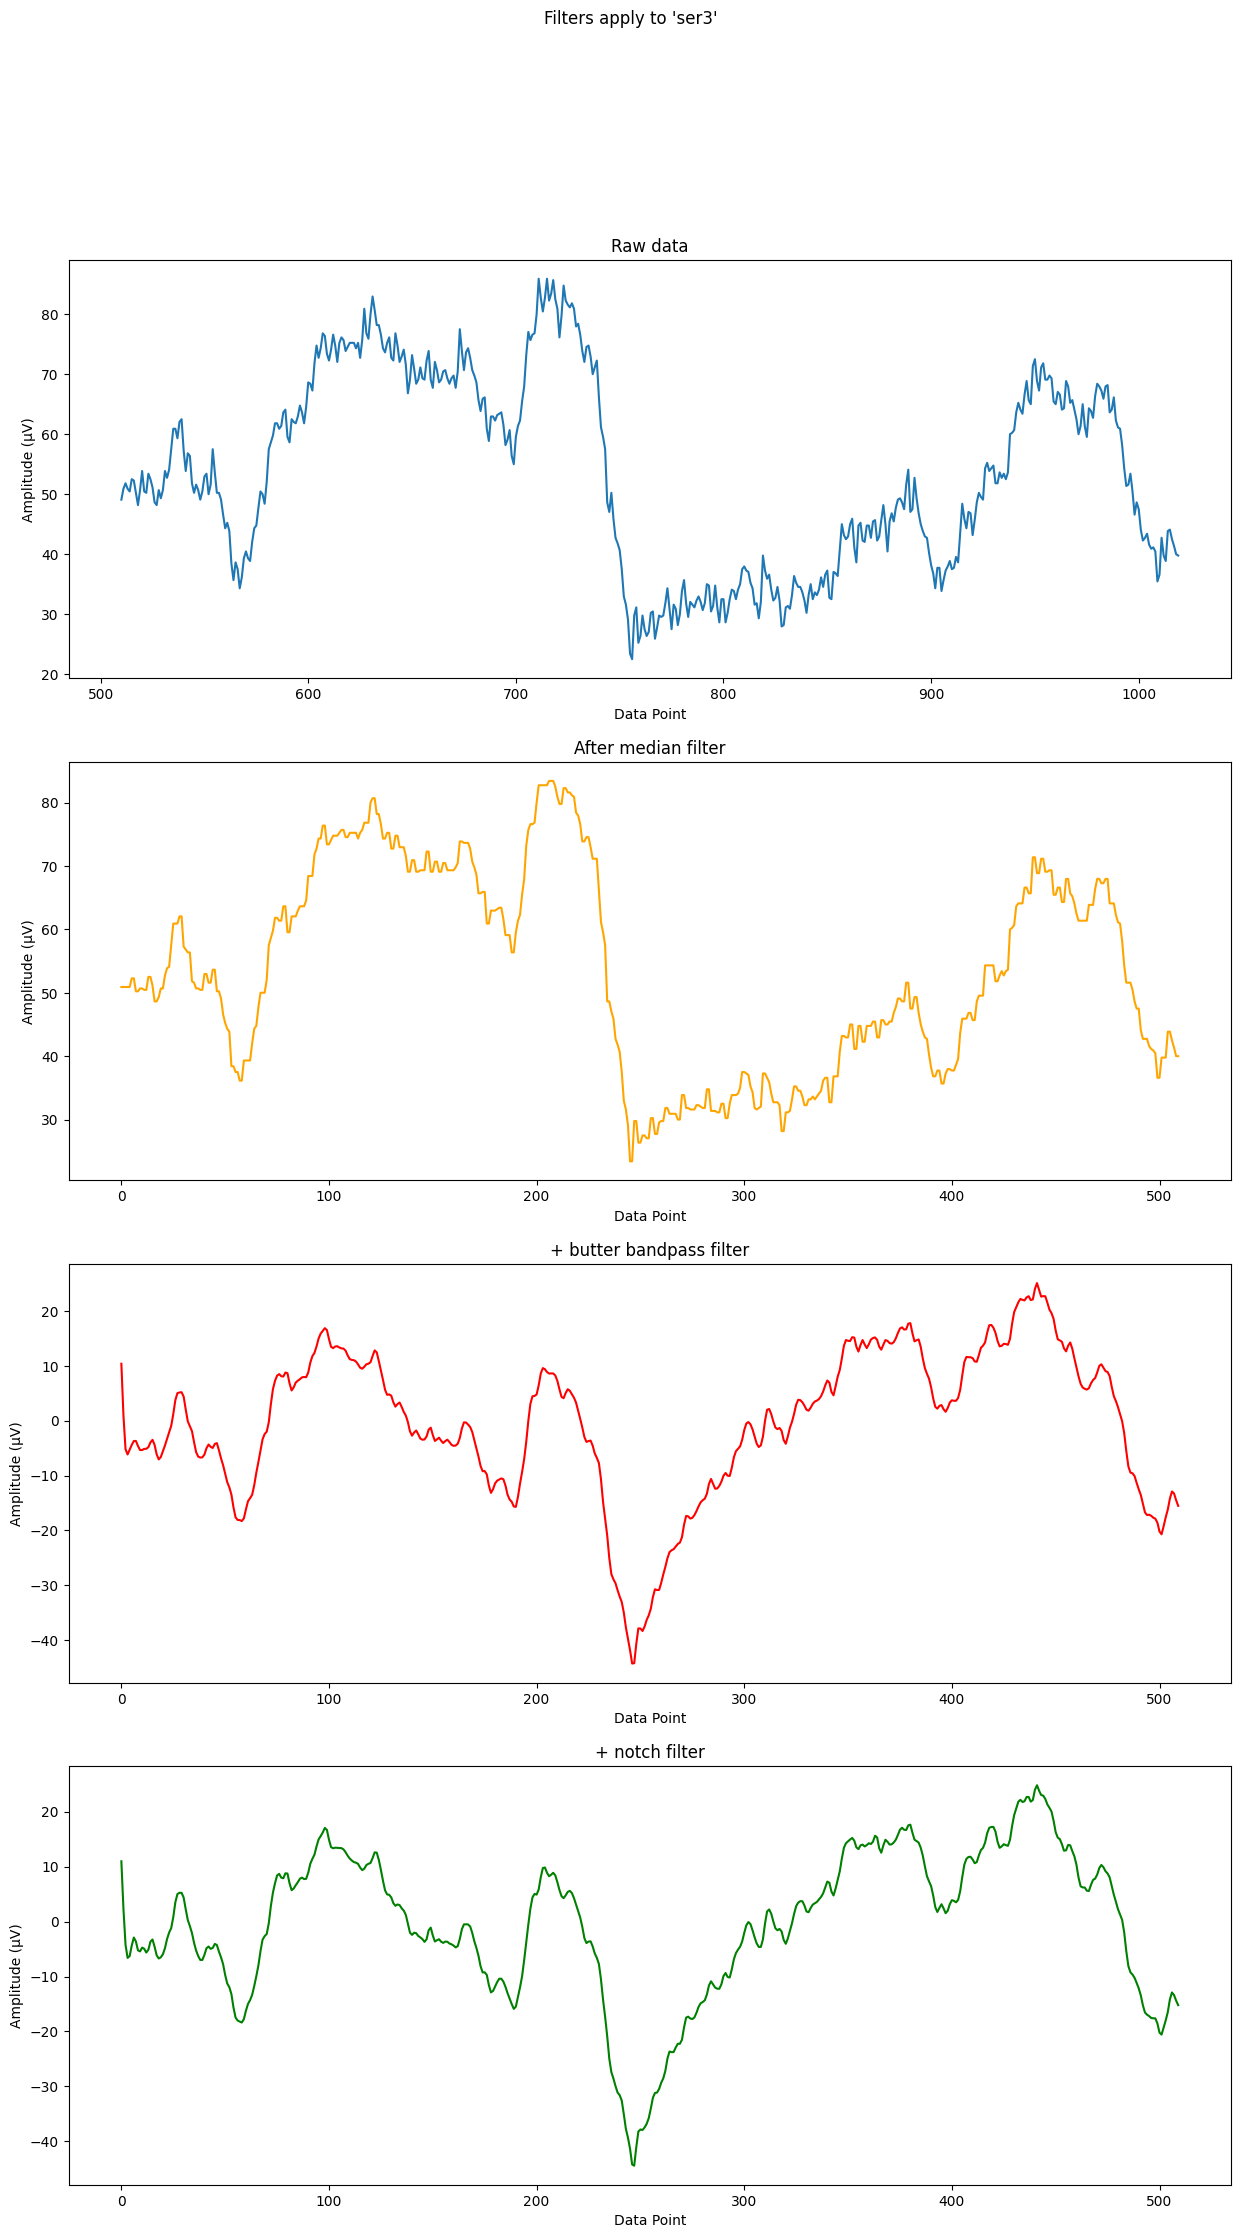

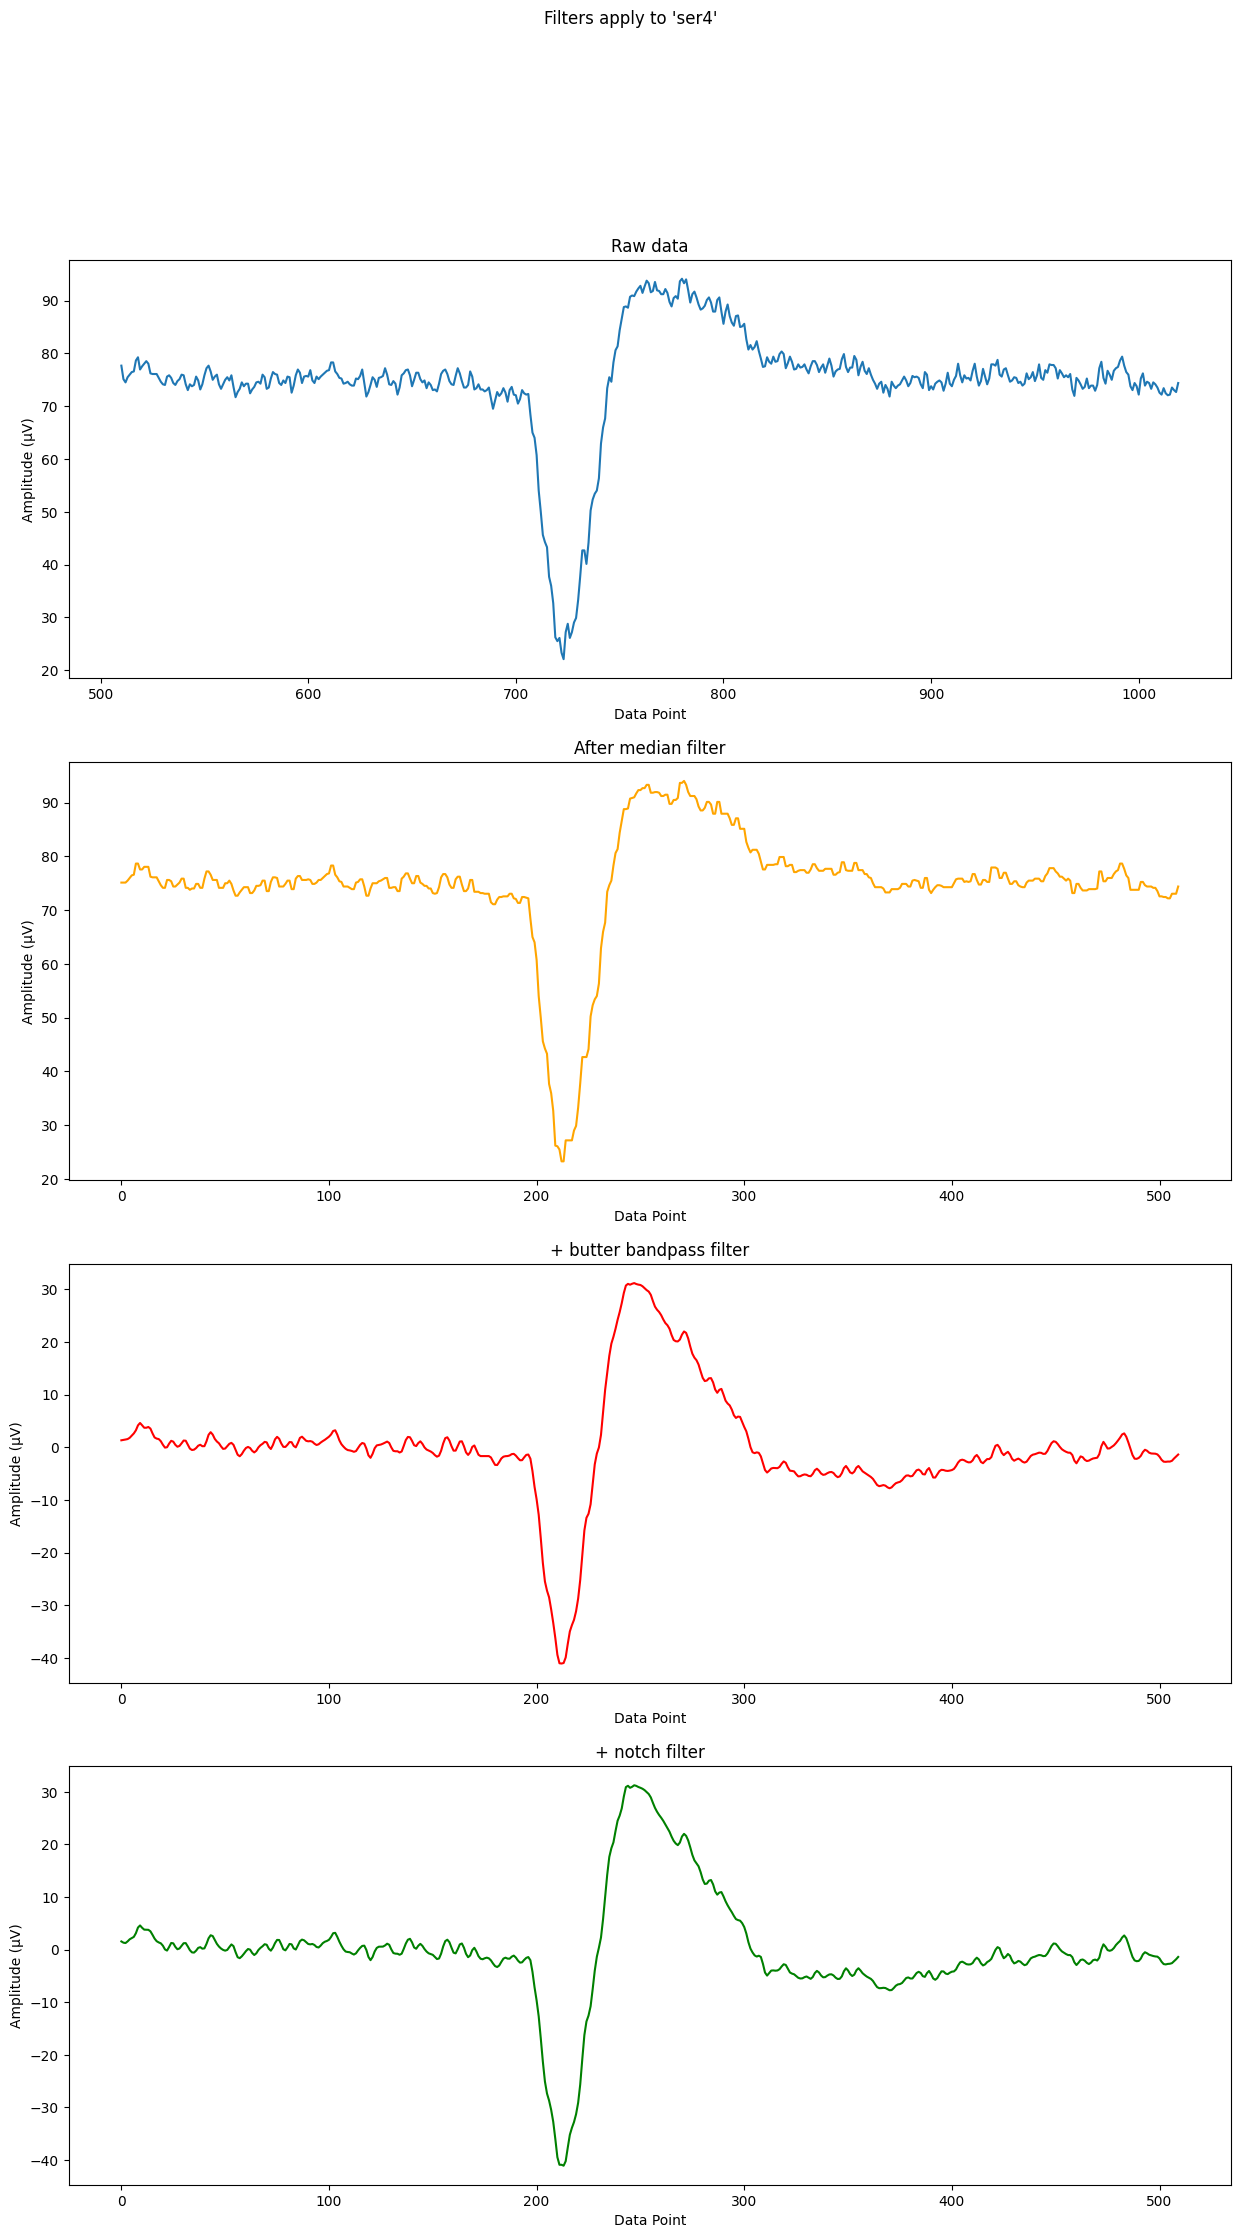

In [20]:
sb_cleaned = preprocessing(data_sb, SLICE_FROM, SLICE_TO)
print(sb_cleaned)


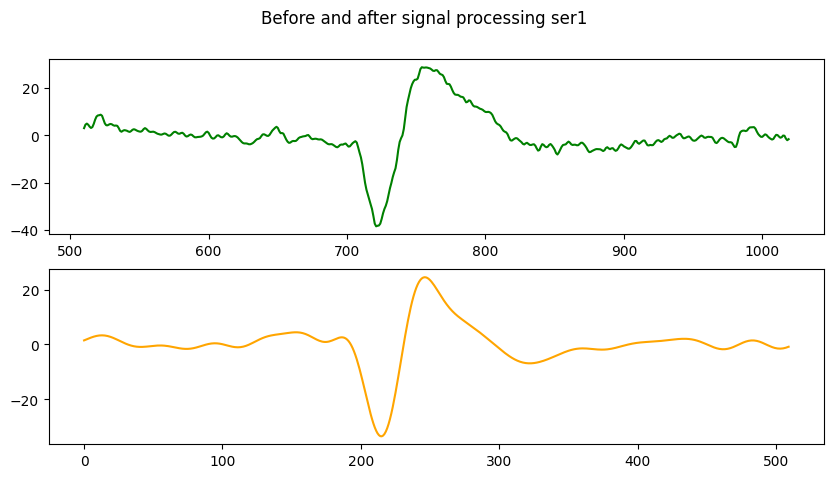

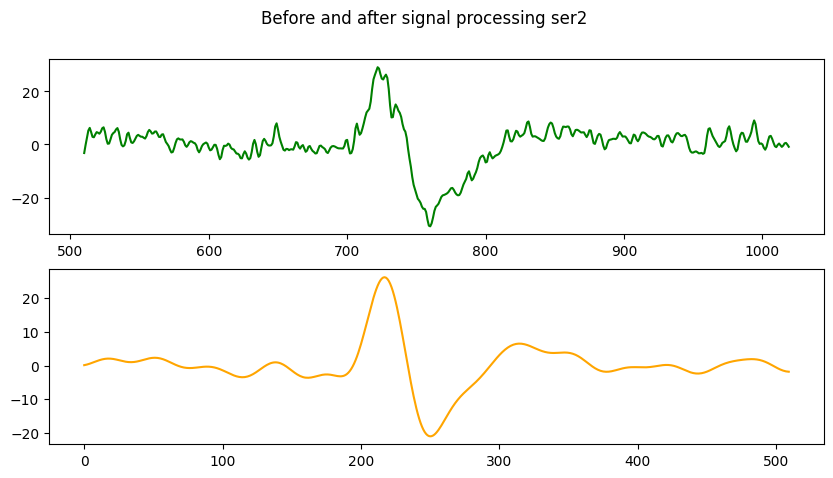

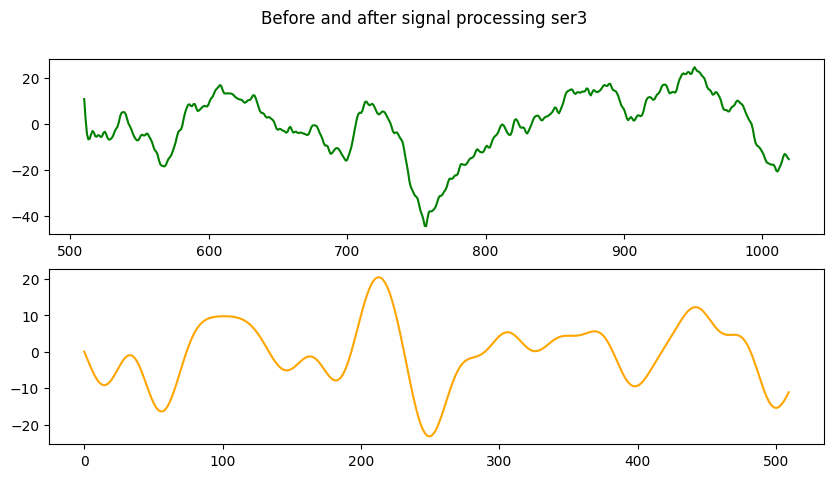

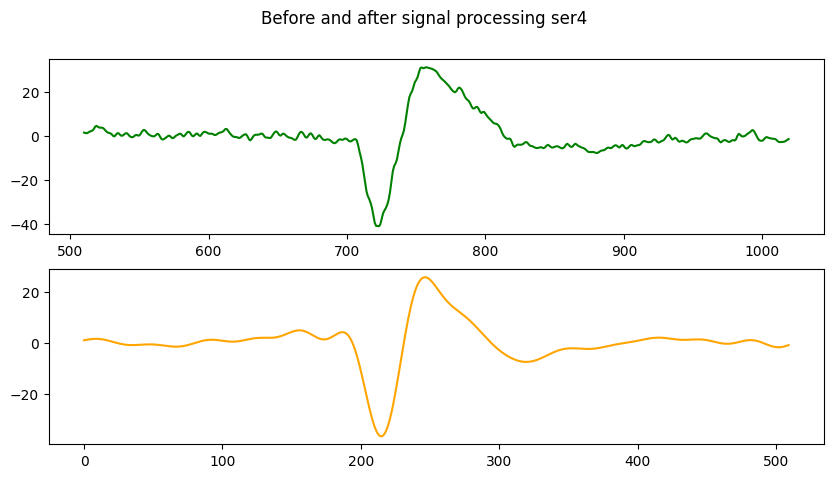

In [21]:
sb_filtered = processing_fir_filter(sb_cleaned, filter)

**2. Feature Extraction**

2.1 Binarization

The dataset, comprising 25,500 rows, is segmented into batches, with each batch corresponding to a blink epoch of 2 seconds. Each epoch consists of 510 rows, resulting in a total of 50 blinks (including both long and short blinks). This segmentation leads to 50 chunks, each containing 510 data points. Subsequently, a new column is added to classify the filtered dataset into two classes, denoted as 0 and 1. To facilitate time series processing, a function is created to split the data into 100 batches, each containing 4 rows of 510. The batched data are then transposed, treating each array as a unit model for processing.

2.2 Statistical Extraction of Features

Subsequently, statistical feature extraction is employed to identify important signal attributes such as amplitude variation. These features offer valuable insights into the signal and contribute to the system's accuracy. While these statistical features provide valuable information, studies suggest that relying solely on them may not yield a comprehensive diagnosis as they may fall short in capturing the full complexity of brain signals. The statistical features used are:

1) Mean

Mean represents the average value of the EEG signal across the selected time domain.Changes in the mean may indicate shifts in the baseline or overall amplitude of the signal. It can be calculated by using Eq. below:

![mean.png](image/mean.png)

2) Variance

Variance provides information about the spread or dispersion of amplitude values in the signal. Specifically, variance quantifies how much individual data points in the signal deviate from the mean (average) value. A higher variance indicates greater variability in the amplitude values, while a lower variance suggests that the values are more tightly clustered around the mean. 

3) Energy

Energy is calculated to find the spreading out of the data values around the mean.Energy provides information about the intensity or power of the signal. Peaks in energy may correspond to periods of increased neural activity or certain events captured by the EEG. It can be calculated by using Eq. below:

![Energy.png](image/Energy.png)

4) Standard Deviation

Standard deviation measures the amount of variability or dispersion of the EEG signal values around the mean.A higher standard deviation suggests greater variability in signal amplitudes. It can be indicative of the signal's overall volatility or the presence of irregularities. It can be calculated by using Eq. below:

![std.png](image/std.png)

5) Kurtosis

In a probability distribution, it measures the outliers present. It can be calculated by using Eq. below:

![Kurtosis.png](image/Kurtosis.png)

6) Skewness

Skewness describes asymmetry from the normal distribution in a set of statistical data, as data becomes more symmetrical as its value approaches zero. Normally distributed data, by definition has little skewness and on other hand positively skewed or right sided skewed data has positive and negatively skewed or left sided skewed has negative value. It can be calculated by using Eq. below:

![Skewness.png](image/Skewness.png)


| Statistical features      | Long blink  | Short blink |
| -----------               | ----------- |-----------  |
| Mean                      | 0.019291    |  0.02110    |
| Variance                  |1.844759e+01 |4.101056e+01 |
| Energy                    |1.881693e+06 |4.183123e+06 |
| Standard Deviation        |4.3          |6.4          |
| Kurtosis                  |3.78         |7.82         |
| Skewness                  |-0.0121      |-0.0226      |

It is observed that the mean and skewness do not show much variation between the two classes. On the other hand, variance, energy, standard deviation, and kurtosis show some good variation between the two classes. Therefore, the parameters *Variance*, *Energy*, *Standard deviation*, and *Kurtosis* are considered for analysis.

**Reference**
- [Selection of Appropriate Statistical Features of EEG Signals for Detection of Parkinson’s Disease](https://ieeexplore.ieee.org/document/9200194/authors#authors)
- [Detection of Epileptic Seizure in EEG Recordings by Spectral Method and Statistical Analysis](https://scialert.net/fulltext/?doi=jas.2013.207.219)

**Source code**
- [EEG Features](https://github.com/vancleys/EEGFeatures/blob/master/TimeDomain/Mean.py)
- [EEG ML Classification](https://github.com/talhaanwarch/youtube-tutorials/blob/main/2.1%20EEG%20ML%20classification.ipynb)
- [Annotation](https://matplotlib.org/2.0.2/users/annotations.html#:~:text=pad%3D0.6%22)

In [22]:
lb_filtered.shape
sb_filtered.shape

(25500, 4)

In [23]:
# number of batch per sequence
25500/510


50.0

In [24]:
# Create a function to split data into batches 
def get_transposed_numpy_batched_array(array: np.array, batch_size: int):
    l = []
    for i in range(batch_size, len(array)+batch_size, batch_size):
        l.append(array[i-batch_size:i].T.to_numpy())
    print(array[i-batch_size:i].T)
    return np.array(l)

# Create an array of long blink epochs and class labels
long_blink_epochs_array = get_transposed_numpy_batched_array(lb_filtered, 510)
long_blink_labels = len(long_blink_epochs_array)*[1]

# Create an array of short blink epochs and class labels
short_blink_epochs_array = get_transposed_numpy_batched_array(sb_filtered, 510)
short_blink_labels = len(short_blink_epochs_array)*[0]

# Concatenate the long and short blink epochs and class labels to create the final dataset for training
blink_epochs_array = np.concatenate([long_blink_epochs_array, short_blink_epochs_array])
blink_labels = np.concatenate([long_blink_labels, short_blink_labels])


blink_epochs_array.shape, blink_labels.shape, long_blink_epochs_array.shape

         24990     24991     24992     24993     24994     24995     24996  \
ser1  1.326038  1.359235  1.379502  1.386978  1.382109  1.365510  1.337939   
ser2  4.195734  4.234542  4.215589  4.138769  4.005085  3.816556  3.576058   
ser3  0.522190  0.449767  0.364770  0.269902  0.167993  0.061858 -0.045870   
ser4  1.001382  1.038242  1.063196  1.075887  1.076302  1.064563  1.040967   

         24997     24998     24999  ...     25490     25491     25492  \
ser1  1.300554  1.254809  1.202157  ...  0.913804  0.877121  0.837937   
ser2  3.287241  2.954543  2.583075  ... -2.140334 -2.458486 -2.739705   
ser3 -0.152643 -0.256087 -0.354329  ...  0.531277  0.553239  0.556501   
ser4  1.006324  0.961831  0.908741  ...  0.583350  0.572965  0.560713   

         25493     25494     25495     25496     25497     25498     25499  
ser1  0.796768  0.754239  0.710973  0.667545  0.624533  0.582459  0.541719  
ser2 -2.979738 -3.175172 -3.323546 -3.423352 -3.474028 -3.475970 -3.430527  
ser3  0.5410

((100, 4, 510), (100,), (50, 4, 510))

In [25]:
blink_epochs_array.shape

(100, 4, 510)

In [26]:
pd.DataFrame(blink_epochs_array[0])

0          1          2          3          4          5          6    \
0  7.191841  10.074215  12.916299  15.677516  18.318712  20.802860  23.095776   
1  8.383751  11.295406  14.152239  16.911520  19.532092  21.975227  24.205492   
2  5.949532   8.535834  11.091077  13.577756  15.959519  18.201905  20.273015   
3  6.888777   9.769685  12.612580  15.376632  18.022433  20.512675  22.812887   

         7          8          9    ...       500       501       502  \
0  25.166958  26.990186  28.543974  ...  0.372850  0.340737  0.301772   
1  26.191524  27.906688  29.329637  ...  0.966434  0.569307  0.142761   
2  22.144330  23.791359  25.194010  ...  2.133097  1.935580  1.711226   
3  24.892304  26.724448  28.287585  ...  0.291914  0.254831  0.212897   

        503       504       505       506       507       508       509  
0  0.258013  0.211690  0.165091  0.120571  0.080455  0.046927  0.022022  
1 -0.304696 -0.763903 -1.225225 -1.678786 -2.114726 -2.523458 -2.895947  
2  1.461997  1.190318  0.898952  0.591048  0.270078 -0.060304 -0.396206  
3  0.168257  0.123107  0.079619  0.039965  0.006187 -0.019902 -0.036664  

[4 rows x 510 columns]

In [27]:
# Create a group list for the blink epochs as part of EEG ML classification model 
groups_list=[i for i, _ in enumerate(blink_epochs_array)]

In [28]:
from scipy import stats 

def mean(data, axis=None):
    return np.mean(data, axis=axis)

def var(data, axis=None):
        return np.var(data, axis=axis)
    
def std(data, axis=None):
    return np.std(data, axis=axis)

def energy(data, axis=None):
    return np.sum(np.square(data), axis=axis) 

def kurtosis(data, axis=None):
    return stats.kurtosis(data,axis=axis)

def skewness(data, axis=None):
     return stats.skew(data, axis=axis)

def concatenate_features(data, axis=None):
    return np.concatenate((var(data, axis=axis), std(data, axis=axis), energy(data, axis=axis), kurtosis(data, axis=axis)), axis=axis)


1.929120e-02
1.844759e+01
1.881693e+06
4.295066e+00
3.799971e+00
-1.210304e-01
2.110281e-02
4.101056e+01
4.183123e+06
6.403949e+00
7.819853e+00
-2.225644e-01


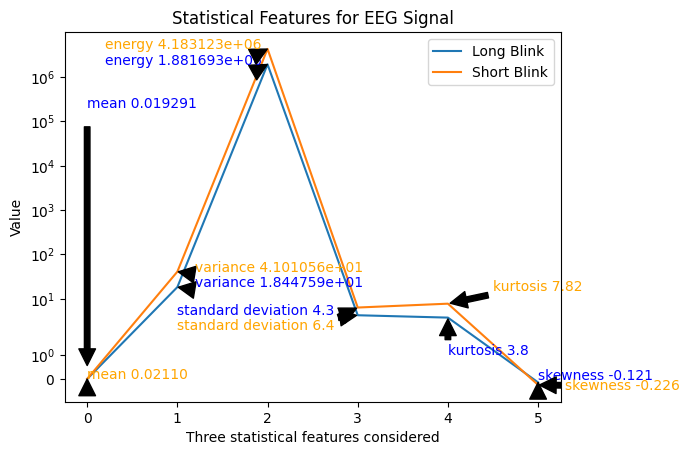

In [29]:
# Calculate statistical features for each column

lb_mean_values = mean(long_blink_epochs_array)
lb_var_values = var(long_blink_epochs_array)
lb_energy_values = energy(long_blink_epochs_array)
lb_std_values = std(long_blink_epochs_array)
lb_kurtosis_values = kurtosis(long_blink_epochs_array)
lb_skew_values = skewness(long_blink_epochs_array)

print("{:e}".format(lb_mean_values))
print("{:e}".format(lb_var_values))
print("{:e}".format(lb_energy_values))
print("{:e}".format(lb_std_values))
print("{:e}".format(lb_kurtosis_values))
print("{:e}".format(lb_skew_values))


sb_mean_values = mean(short_blink_epochs_array)
sb_var_values = var(short_blink_epochs_array)
sb_energy_values = energy(short_blink_epochs_array)
sb_std_values = std(short_blink_epochs_array)
sb_kurtosis_values = kurtosis(short_blink_epochs_array)
sb_skew_values = skewness(short_blink_epochs_array)

print("{:e}".format(sb_mean_values)) 
print("{:e}".format(sb_var_values))
print("{:e}".format(sb_energy_values))
print("{:e}".format(sb_std_values ))
print("{:e}".format(sb_kurtosis_values))
print("{:e}".format(sb_skew_values))


# Create a list of statistical feature names
feature_names = ["Mean", "Variance", "Energy", "Standard Deviation", "Kurtosis", "Skewness"]

# Create a list of statistical feature values for each column
lb_feature_values = [lb_mean_values, lb_var_values, lb_energy_values, lb_std_values, lb_kurtosis_values, lb_skew_values]
sb_feature_values = [sb_mean_values, sb_var_values, sb_energy_values, sb_std_values, sb_kurtosis_values, sb_skew_values]

l = [i for i in range(len(feature_names))]

# Plot each statistical feature for each column

plt.plot(l, lb_feature_values, label="Long Blink" )
plt.plot(l, sb_feature_values, label="Short Blink")  

plt.xlabel("Three statistical features considered")  # Assuming each feature value corresponds to an epoch
plt.ylabel("Value")

# # Plot the selected statistical values for long blink epochs
plt.annotate('mean 0.019291', xy=(0, 0.019291), xytext=(0, 200000.019291), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('variance 1.844759e+01', xy=(1, 1.844759e+01), xytext=(1.2, 1.844759e+01), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('energy 1.881693e+06', xy=(2, 1.881693e+06), xytext=(0.2, 1.881693e+06), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('standard deviation 4.3', xy=(3, 4.3), xytext=(1, 4.3), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('kurtosis 3.8', xy=(4, 3.8), xytext=(4, 1), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('skewness -0.121', xy=(5, -0.121), xytext=(5, -0.0121), color = "blue", arrowprops=dict(facecolor='black', shrink=0.05))


# Plot the selected statistical values for short blink epochs
plt.annotate('mean 0.02110', xy=(0, 0.02110), xytext=(0, 0.02110), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('variance 4.101056e+01', xy=(1, 4.101056e+01), xytext=(1.2, 4.101056e+01), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('energy 4.183123e+06', xy=(2, 4.183123e+06), xytext=(0.2, 4.183123e+06), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('standard deviation 6.4', xy=(3, 6.4), xytext=(1, 2), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('kurtosis 7.82', xy=(4, 7.82), xytext=(4.5, 15), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('skewness -0.226', xy=(5, -0.226), xytext=(5.3, -0.4), color = "orange", arrowprops=dict(facecolor='black', shrink=0.05))


plt.title(f"Statistical Features for EEG Signal")
plt.yscale("symlog", base=10)
plt.legend()

plt.show()

In [30]:
# 100 rows of 16 features, 4 features for each of the 4 channels
features_list=[]
for data in blink_epochs_array:
    features_list.append(concatenate_features(data, axis=-1))
features=np.array(features_list)
features.shape

(100, 16)

**3. Biomarker Selection and Visualization**

In the context of biomarker selection, the random forest algorithm, which employs multiple decision tree classifiers on various subsets of the dataset is applied. Averaging is used to enhance predictive accuracy and control overfitting.

To determine the optimal number of trees, five-fold cross-validation is applied. Interestingly, all estimators `n_trees in [50, 100, 200, 500]` achieved perfect accuracy on the training data. As a result, the retained features are applied with the smallest number of trees `n_estimators = 50`. 

The selected biomarkers consist of 16 statistical features (4 features for each of the 4 electrodes). These features are extracted from 75% of the datasets, and two classes are considered. The visualized plot illustrates the sequences of statistical features from top to bottom as *Variance*, *Energy*, *Standard deviation*, and *Kurtosis*. Long blinks are annotated with a green dotted line, while short blinks are annotated with a red dotted line. The visual inspection indicates that the majority of long blinks (associated with eye disorder) appear flat, while short blinks (healthy state) display spikes. This distinction is particularly noticeable, especially in the *Kurtosis* feature.

**Reference**
- [Feature Selection with Random Forest](https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/)
- [Understanding Random Forest Better through Visualization](https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f)

**Reference Code**
- [stackoverflow](https://stackoverflow.com/questions/6146290/plotting-a-line-over-several-graphs)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(features, blink_labels, test_size=0.25, random_state=42, shuffle=True)

for n_trees in [50, 100, 200, 500]:
    # Create RandomForestClassifier with current n_estimators
    forest = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    
    # Use cross_val_score for evaluation
    scores = cross_val_score(forest, X_train, y_train, cv=5)  # 5-fold cross-validation
    mean_score = scores.mean()
    
    print(f"n_estimators={n_trees}, Mean Cross-Validation Score: {mean_score}")

n_estimators=50, Mean Cross-Validation Score: 1.0
n_estimators=100, Mean Cross-Validation Score: 1.0
n_estimators=200, Mean Cross-Validation Score: 1.0
n_estimators=500, Mean Cross-Validation Score: 1.0


In [32]:
# Create and train a random forest (code is learned from kaggle on other dataset irrelavant to this project)
forest= RandomForestClassifier(n_estimators= 50, random_state= 42)
forest.fit(X_train, y_train)

# Get the most important features
forest_feats= SelectFromModel(forest, threshold= 'median')
forest_feats.fit(X_train, y_train)

# Get training and development sets that have only the most important features
X_train_forest= forest_feats.transform(X_train)
X_devel_forest= forest_feats.transform(X_test) 

# Features that will be retained
for i in forest_feats.get_support(indices= True):
    print(X_train[i])



[1.84996289e+01 2.14093600e+01 6.10969960e+00 1.41348556e+01
 4.30111949e+00 4.62702496e+00 2.47178065e+00 3.75963503e+00
 9.47132996e+03 1.09610215e+04 3.12248648e+03 7.23839558e+03
 3.13001072e+00 1.16193394e+00 3.24424130e+00 3.23820203e+00]
[2.13879296e+01 2.54391386e+01 6.93365097e+00 1.57896687e+01
 4.62470860e+00 5.04372269e+00 2.63318267e+00 3.97362161e+00
 1.09079151e+04 1.29764057e+04 3.53616204e+03 8.05273226e+03
 2.20585597e+00 1.53730207e+00 2.28606066e+00 2.13445454e+00]
[2.46129840e+01 1.23984202e+01 1.92105428e+01 2.89592528e+01
 4.96114745e+00 3.52113904e+00 4.38298332e+00 5.38138020e+00
 1.25538952e+04 6.32931057e+03 9.81648532e+03 1.47723885e+04
 7.70269905e+00 2.49198126e+00 4.15076902e+00 7.27519860e+00]
[3.60615826e+01 2.88924646e+01 1.60845103e+01 4.18471233e+01
 6.00512969e+00 5.37517112e+00 4.01054988e+00 6.46893525e+00
 1.83932013e+04 1.47387562e+04 8.20590652e+03 2.13434248e+04
 6.54080724e+00 6.90711547e+00 6.64659068e+00 6.79244336e+00]
[2.34665591e+01 1.52

In [33]:
df3 = pd.DataFrame(np.concatenate((X_train, y_train[:, None]), axis=1)) #y_train[:, None] only take the first column
df3.head(5), df3.shape

(          0          1          2          3         4         5         6   \
 0  18.499629  21.409360   6.109700  14.134856  4.301119  4.627025  2.471781   
 1  17.969534  21.871694  10.193961  13.800093  4.239049  4.676718  3.192798   
 2  52.052397  23.505903  57.219021  57.473810  7.214735  4.848289  7.564326   
 3  21.387930  25.439139   6.933651  15.789669  4.624709  5.043723  2.633183   
 4  24.612984  12.398420  19.210543  28.959253  4.961147  3.521139  4.382983   
 
          7             8             9             10            11        12  \
 0  3.759635   9471.329956  10961.021521   3122.486477   7238.395584  3.130011   
 1  3.714848   9165.424406  11157.821814   5199.135402   7039.091659  1.734216   
 2  7.581148  26546.903891  11990.035470  29181.970190  29312.028613  8.259887   
 3  3.973622  10907.915143  12976.405725   3536.162040   8052.732256  2.205856   
 4  5.381380  12553.895153   6329.310566   9816.485324  14772.388513  7.702699   
 
          13        14  

Text(0, 0.5, 'Amplitude of the features')

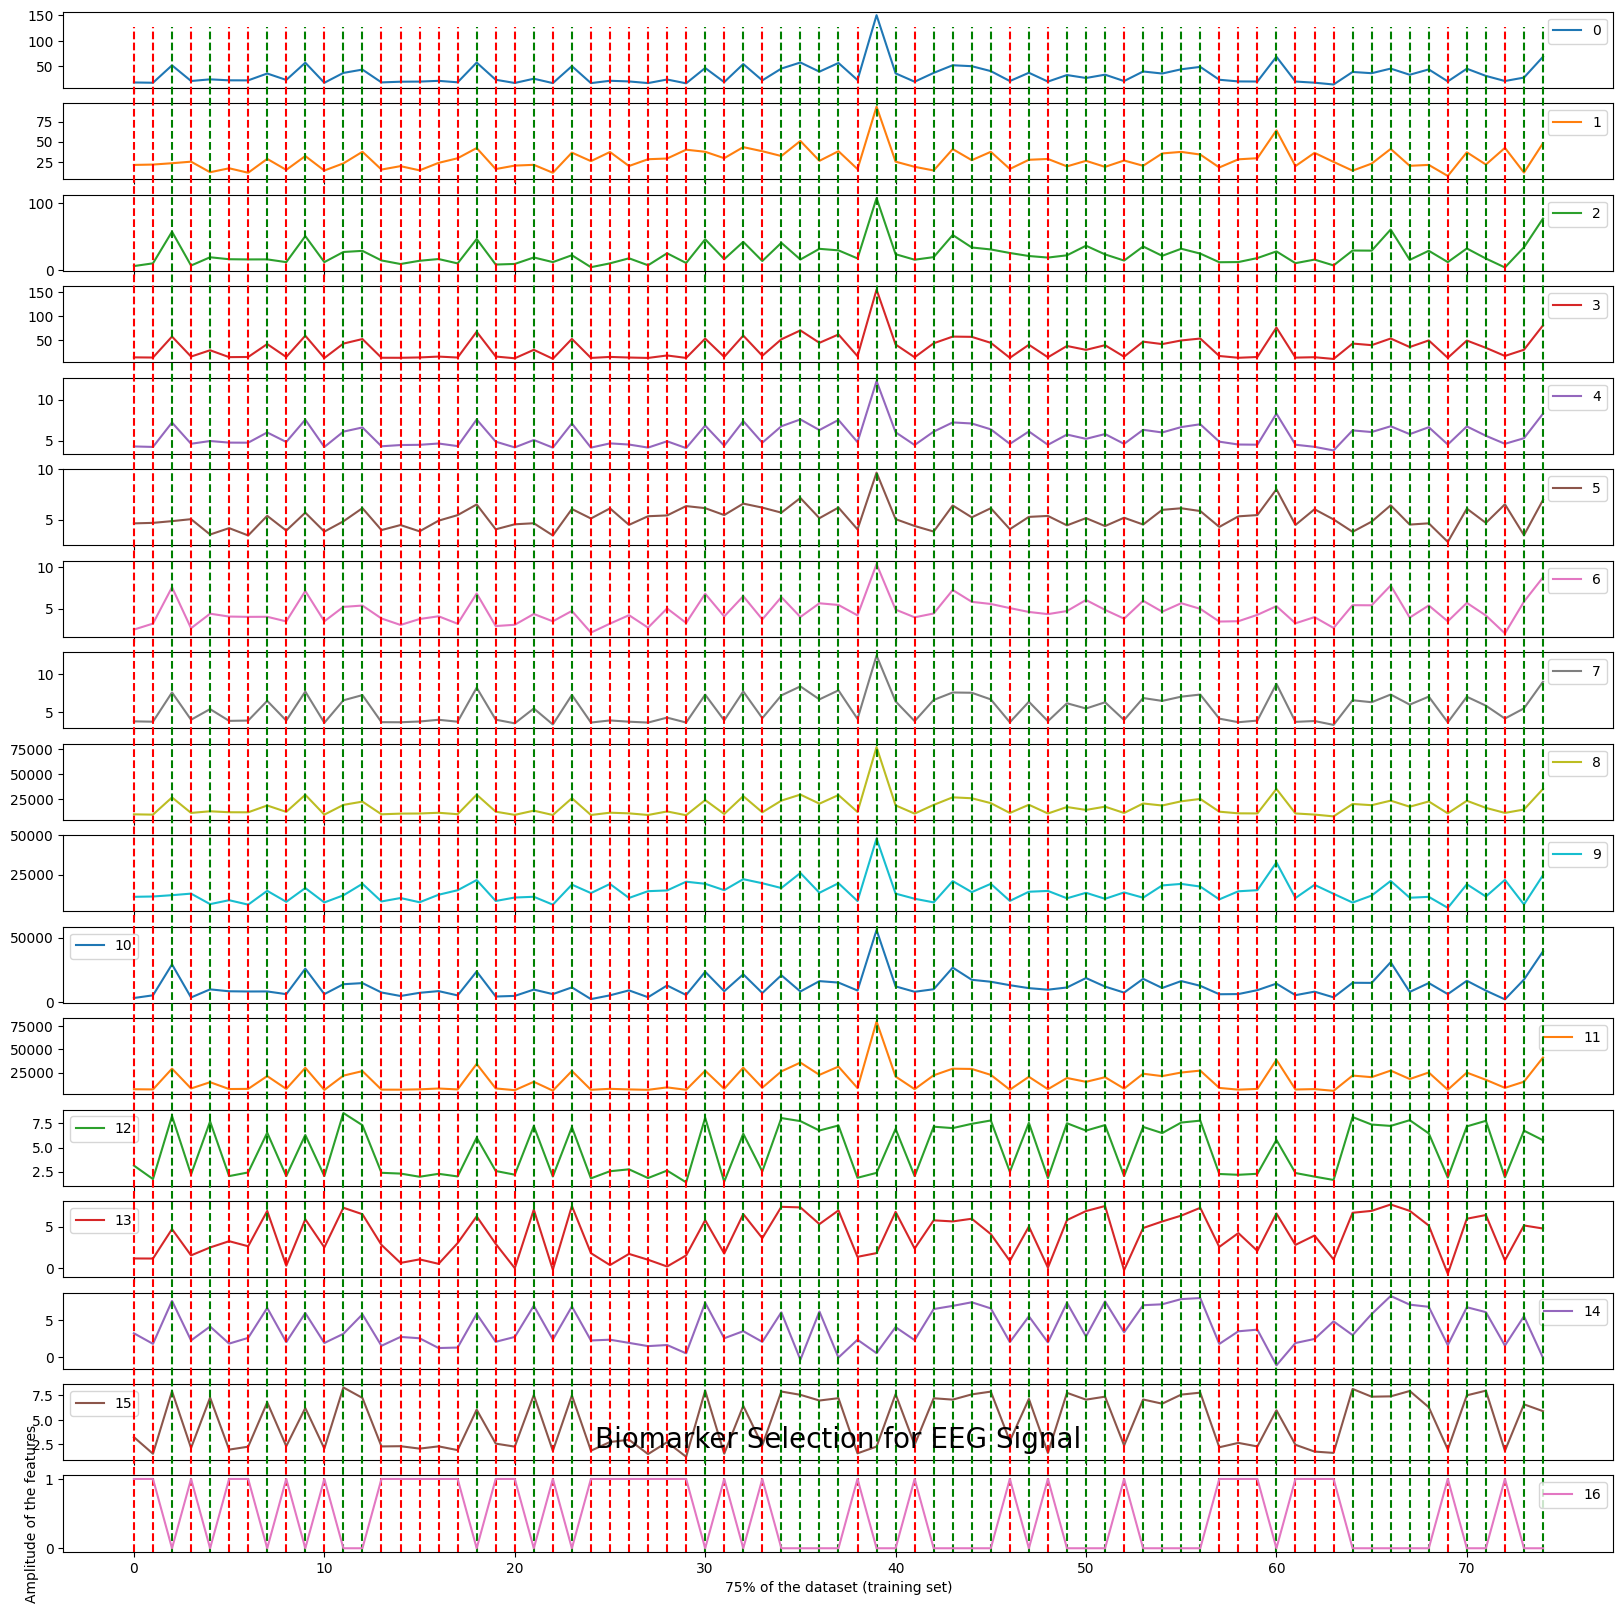

In [34]:
df3.plot.line(subplots=True, figsize=(20, 20))
plt.rcParams['figure.constrained_layout.use'] = True
plt.title('Biomarker Selection for EEG Signal', pad=20, loc='center', fontsize=20)
for i in range(len(df3)):
    if df3.iloc[i,-1:].values == 1:
        # if 1 == long blink and print red line
        plt.axvline(x=i, ymin=0, ymax=20, color='red', linestyle='--',zorder=0, clip_on=False)
    else:
        # if 0 == short blink and print green line
        plt.axvline(x=i, ymin=0, ymax=20, color='green', linestyle='--',zorder=0, clip_on=False)
    # plt.axvline(x=column_series[-1], color='black', linestyle='--')
plt.xlabel('75% of the dataset (training set)')
plt.ylabel('Amplitude of the features')


In [35]:
X_train_forest.shape, y_train.shape

((75, 8), (75,))

**4. Algorithm Development**


**Reference Code**
- [Applying Machine Learning Methods](https://github.com/aath0/AlgorithmsNeuroscience/blob/master/Tutorials/ApplyingMachineLearningMethods_1.ipynb)



In [53]:
# Model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Assuming you have 2 classes (binary classification)
num_classes = 2

# Build the model
model_1 = Sequential()
model_1.add(Dense(20, activation="sigmoid", input_shape=(8, )))
model_1.add(Dense(num_classes, activation="softmax"))

# Compile the model
model_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()


# Assuming y_train is your original label array
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

print(y_train_one_hot.shape, X_train_forest.shape)

# Compile the model
print("Compile the model")
model_1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print('\n---')

# Train the model
print("Train the model")
model_1.fit(X_train_forest, y_train_one_hot, epochs=10, batch_size=20)
print('\n---')

# Evaluate the model on the test data
print("Evaluate the model on the test data")
test_loss, test_acc = model_1.evaluate(X_devel_forest, y_test_one_hot)
print('Test accuracy:', test_acc)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                180       
                                                                 
 dense_10 (Dense)            (None, 2)                 42        
                                                                 
Total params: 222 (888.00 Byte)
Trainable params: 222 (888.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [50]:
from sklearn.metrics import classification_report
y_pred = model_1.predict(X_devel_forest)

# classification_report(y_test, y_pred)
y_pred

1/1 [==============================] - 0s 18ms/step


array([[0.57655084, 0.42344916],
       [0.57655084, 0.42344916],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.5054452 , 0.49455482],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.5054452 , 0.49455476],
       [0.50544506, 0.49455494],
       [0.57655084, 0.42344916],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.57655084, 0.42344916],
       [0.506266  , 0.49373394],
       [0.50544506, 0.49455494],
       [0.50544506, 0.49455494],
       [0.57655084, 0.42344916]], dtype=float32)

In [39]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train_forest, y_train) 

train_score_c4 = svc.score(X_train_forest, y_train)
test_score_c4 = svc.score(X_devel_forest, y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 1.00
Classical SVC on the test dataset:     0.96
